In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'mps'
print(device)

mps
mps


# data transform --> norm, type casting, crop, rotation

In [3]:
train_transform = transforms.Compose([
    transforms.ToTensor(), # 0~1 numpy -> tensor,
    # 0 ~ 1 0-0.5/0.5:-1 (1-0.5)/0.5, -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    # 좌우 반전
    transforms.RandomHorizontalFlip(p=0.5), 
])

test_transform = transforms.Compose([
    transforms.ToTensor(), # 0~1 numpy -> tensor,
    # 0 ~ 1 0-0.5/0.5:-1 (1-0.5)/0.5, -1~1
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainset.data.shape, len(trainset.targets), trainset.targets[:10]

((50000, 32, 32, 3), 50000, [6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

((50000, 32, 32, 3), 50000, [6, 9, 9, 4, 1, 1, 2, 7, 8, 3])

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

In [8]:
images, labels = next(iter(trainloader))

In [9]:
images.shape, labels.shape, images.min(), images.max()

(torch.Size([100, 3, 32, 32]), torch.Size([100]), tensor(-1.), tensor(1.))

(torch.Size([100, 3, 32, 32]), torch.Size([100]), tensor(-1.), tensor(1.))

In [10]:
import matplotlib.pyplot as plt

In [ ]:
images[0].permute(1,2,0).shape

In [ ]:
img = images[1].permute(1,2,0)

In [ ]:
img = img * 0.5 + 0.5

In [ ]:
img.min(), img.max()

In [ ]:
plt.title(classes[labels[1].item()])
plt.imshow(img)
plt.show()

# model init 

In [11]:
class cifar_cnn(nn.Module):
    def __init__(self):
        super(cifar_cnn, self).__init__()
        # layer
        
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=4, out_channels=16, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # 32 x 5 x 5
        
        )
        
        self.fc_layer = nn.Sequential(
            nn.Dropout(0.5), 
            nn.Linear(32*5*5, 64),
            nn.ReLU(inplace=True),
            
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 10)

        )
        
    
    def forward(self, x):
        # 순전파
        
        out = self.conv_layer(x)
        # bx16x5x5 --> 1d --> 400
        out = out.view(out.shape[0], -1)
        
        out = self.fc_layer(out)
        
        
        return out
        
    

In [12]:
model = cifar_cnn()

In [13]:
from torchsummary import summary

In [14]:
summary(model, input_size=((3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 30, 30]             112
              ReLU-2            [-1, 4, 30, 30]               0
            Conv2d-3           [-1, 16, 28, 28]             592
              ReLU-4           [-1, 16, 28, 28]               0
         MaxPool2d-5           [-1, 16, 14, 14]               0
            Conv2d-6           [-1, 32, 12, 12]           4,640
              ReLU-7           [-1, 32, 12, 12]               0
            Conv2d-8           [-1, 32, 10, 10]           9,248
              ReLU-9           [-1, 32, 10, 10]               0
        MaxPool2d-10             [-1, 32, 5, 5]               0
          Dropout-11                  [-1, 800]               0
           Linear-12                   [-1, 64]          51,264
             ReLU-13                   [-1, 64]               0
           Linear-14                   

# model learning 

In [17]:
learning_rate = 0.001 #1e-2

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
epochs = 10
model = model.to(device)
for _epoch in range(epochs):
    for it_batch, (images, labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        
        if (it_batch+1) % 30 == 0:
            print(f'epoch:{_epoch}, batch:{it_batch}, loss{loss.item()}')
            
            with torch.no_grad():
                model.eval()

                correct_ = 0
                total_ = 0

                for it_batch, (images, labels) in enumerate(testloader):
                    images = images.to(device)
                    labels = labels.to(device)                    
                    
                    outputs = model(images)

                    predcits = torch.argmax(outputs, axis=1)
                    correct_ += (labels == predcits).sum()
                    total_ += predcits.shape[0]

                acc = correct_/total_ * 100
                print(f'acc{acc:.2f}, correct{correct_}, total{total_}')
                
                model.train()


epoch:0, batch:29, loss1.3963584899902344
epoch:0, batch:29, loss1.3963584899902344
acc54.89, correct5489, total10000
acc54.89, correct5489, total10000
epoch:0, batch:59, loss1.216317057609558
epoch:0, batch:59, loss1.216317057609558
acc55.06, correct5506, total10000
acc55.06, correct5506, total10000
epoch:0, batch:89, loss1.3082233667373657
epoch:0, batch:89, loss1.3082233667373657
acc55.28, correct5528, total10000
acc55.28, correct5528, total10000
epoch:0, batch:119, loss1.3988133668899536
epoch:0, batch:119, loss1.3988133668899536
acc55.46, correct5546, total10000
acc55.46, correct5546, total10000
epoch:0, batch:149, loss1.4669547080993652
epoch:0, batch:149, loss1.4669547080993652
acc55.45, correct5545, total10000
acc55.45, correct5545, total10000
epoch:0, batch:179, loss1.1234886646270752
epoch:0, batch:179, loss1.1234886646270752
acc55.27, correct5527, total10000
acc55.27, correct5527, total10000
epoch:0, batch:209, loss1.4750890731811523
epoch:0, batch:209, loss1.475089073181152

acc56.52, correct5652, total10000
acc56.52, correct5652, total10000
epoch:3, batch:209, loss1.189419150352478
epoch:3, batch:209, loss1.189419150352478
acc56.93, correct5693, total10000
acc56.93, correct5693, total10000
epoch:3, batch:239, loss1.0571140050888062
epoch:3, batch:239, loss1.0571140050888062
acc56.42, correct5642, total10000
acc56.42, correct5642, total10000
epoch:3, batch:269, loss1.3611727952957153
epoch:3, batch:269, loss1.3611727952957153
acc56.78, correct5678, total10000
acc56.78, correct5678, total10000
epoch:3, batch:299, loss1.3107229471206665
epoch:3, batch:299, loss1.3107229471206665
acc56.57, correct5657, total10000
acc56.57, correct5657, total10000
epoch:3, batch:329, loss1.131833553314209
epoch:3, batch:329, loss1.131833553314209
acc56.56, correct5656, total10000
acc56.56, correct5656, total10000
epoch:3, batch:359, loss1.1788945198059082
epoch:3, batch:359, loss1.1788945198059082
acc56.37, correct5637, total10000
acc56.37, correct5637, total10000
epoch:3, bat

epoch:6, batch:359, loss1.2054301500320435
acc57.12, correct5712, total10000
acc57.12, correct5712, total10000
epoch:6, batch:389, loss1.1128233671188354
epoch:6, batch:389, loss1.1128233671188354
acc57.12, correct5712, total10000
acc57.12, correct5712, total10000
epoch:6, batch:419, loss1.382397174835205
epoch:6, batch:419, loss1.382397174835205
acc57.24, correct5724, total10000
acc57.24, correct5724, total10000
epoch:6, batch:449, loss1.1853854656219482
epoch:6, batch:449, loss1.1853854656219482
acc56.99, correct5699, total10000
acc56.99, correct5699, total10000
epoch:6, batch:479, loss1.3898473978042603
epoch:6, batch:479, loss1.3898473978042603
acc57.21, correct5721, total10000
acc57.21, correct5721, total10000
epoch:7, batch:29, loss1.176179051399231
epoch:7, batch:29, loss1.176179051399231
acc57.47, correct5747, total10000
acc57.47, correct5747, total10000
epoch:7, batch:59, loss1.235304832458496
epoch:7, batch:59, loss1.235304832458496
acc57.23, correct5723, total10000
acc57.23,

# evaluate  

In [19]:
model = model.to('cpu')

In [20]:

with torch.no_grad():
    model.eval()
    
    correct_ = 0
    total_ = 0

    for it_batch, (images, labels) in enumerate(testloader):
        
        outputs = model(images)
        
        predcits = torch.argmax(outputs, axis=1)
        correct_ += (labels == predcits).sum()
        total_ += predcits.shape[0]
    
    acc = correct_/total_ * 100
    print(f'acc{acc:.2f}, correct{correct_}, total{total_}')
    

acc57.43, correct5743, total10000
acc57.43, correct5743, total10000


# Display results

In [85]:
def display_torch_result(images, labels, predicts):
    
    for img, lab, pred in zip(images, labels, predicts):
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        target = classes[lab.item()]
        pred_cls = classes[pred.item()]
        
#         if target != pred_cls:
        _title = f'gt[{target}],p[{pred_cls}]'
        plt.title(_title)
        plt.imshow(img)
        plt.show()
        


In [79]:
iter_test = iter(testloader)
images, labels = next(iter_test)

In [80]:
outputs= model(images)

In [81]:
predicts = torch.argmax(outputs, axis=1)

In [82]:
(labels == predicts).sum()

tensor(63)

tensor(63)

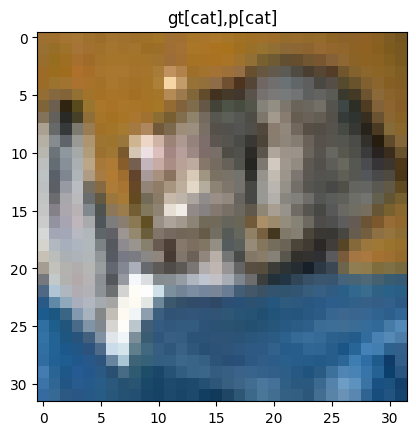

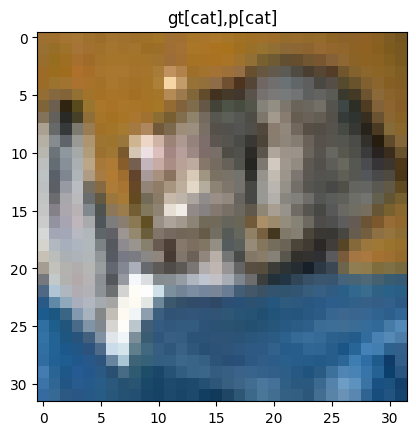

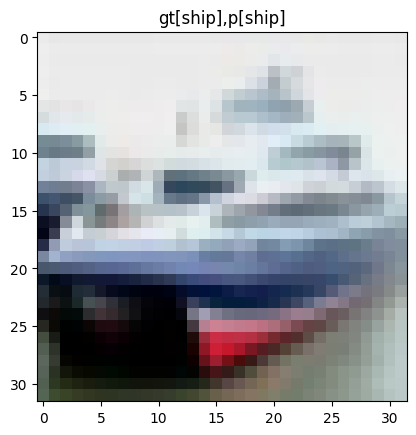

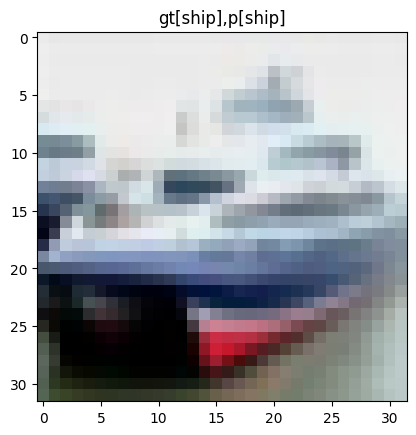

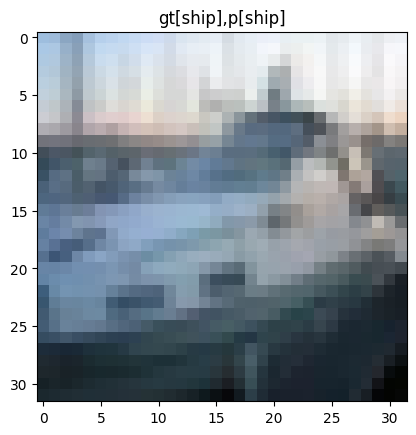

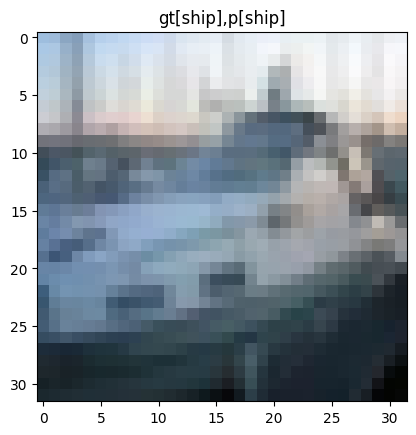

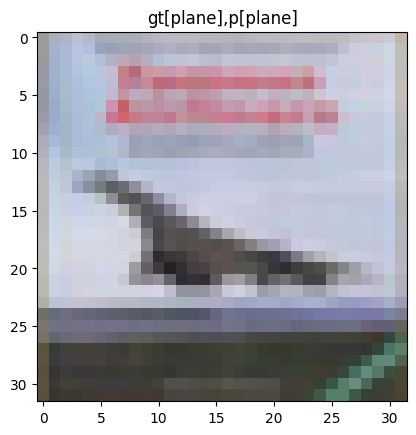

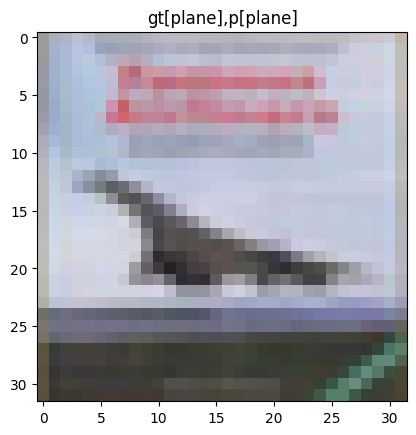

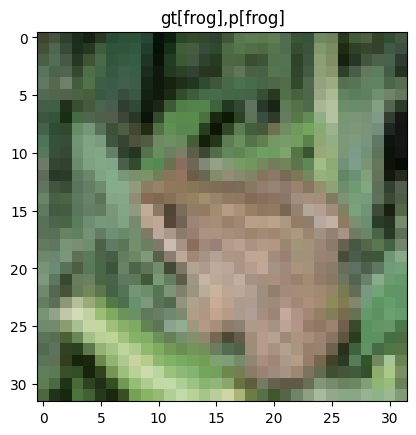

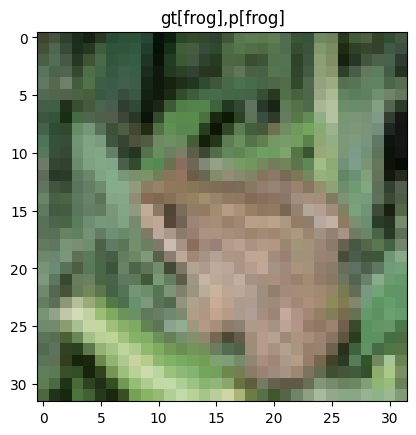

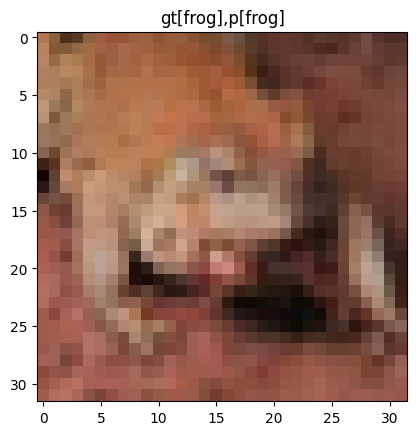

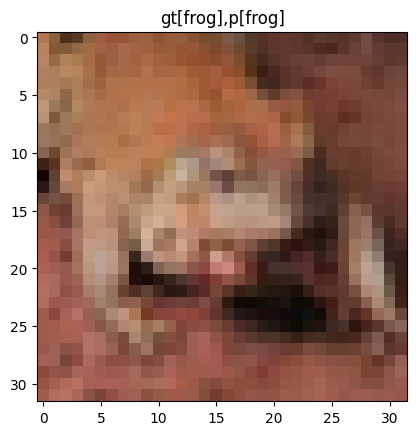

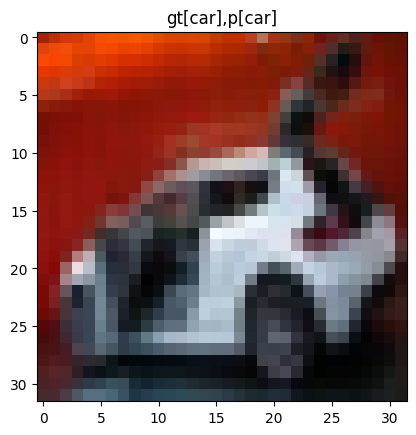

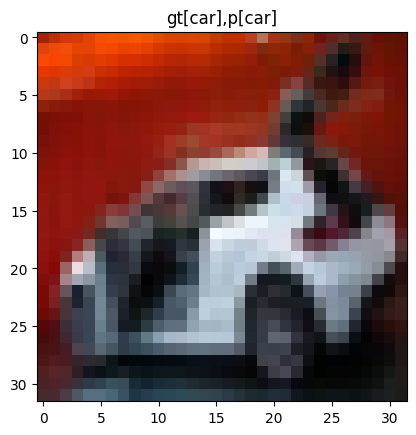

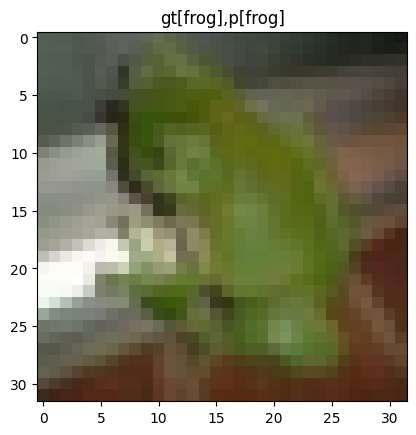

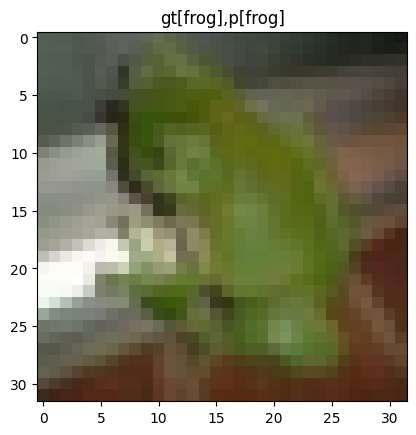

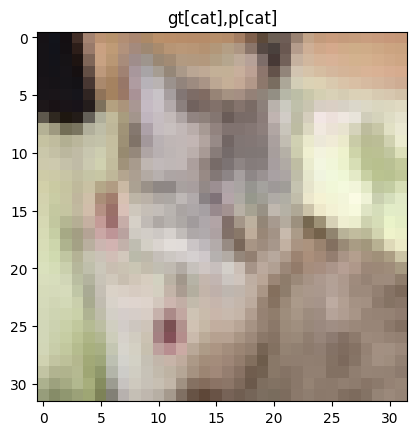

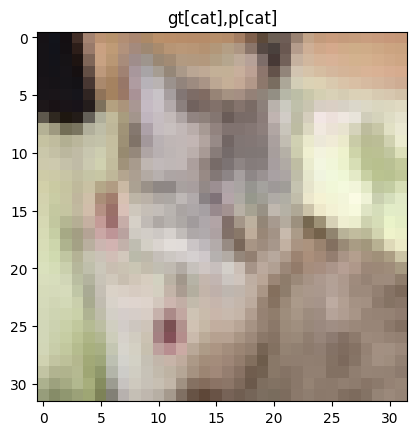

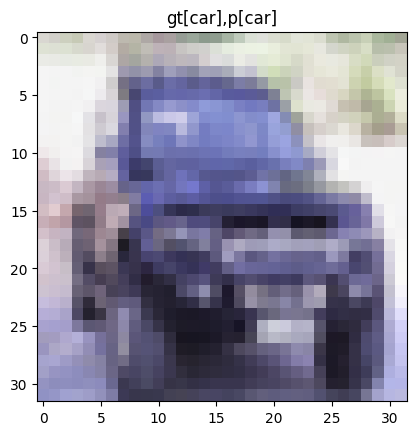

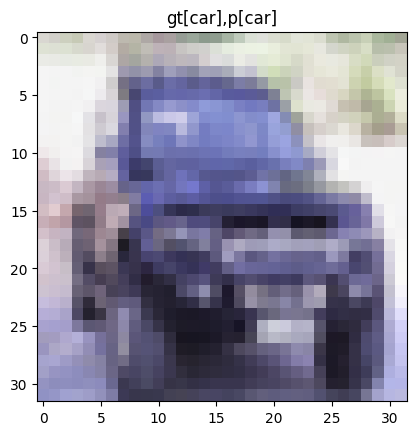

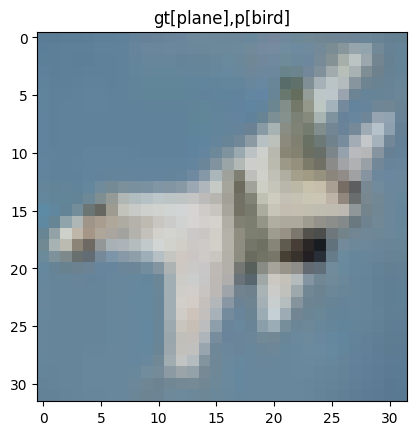

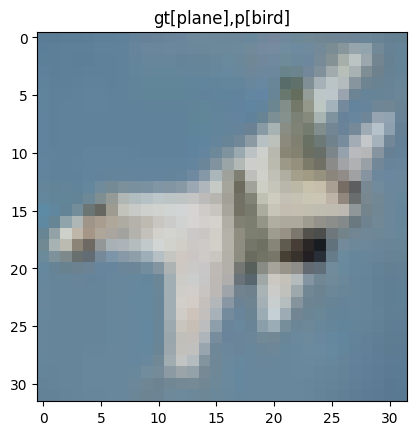

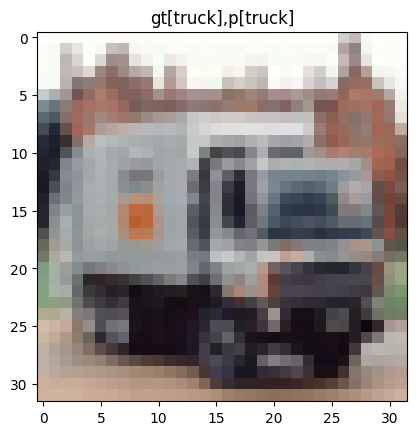

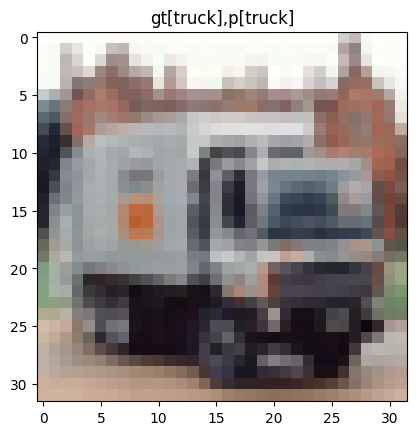

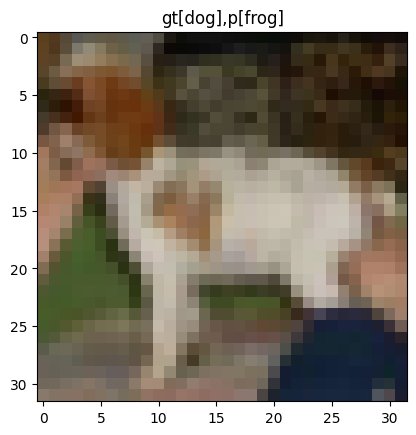

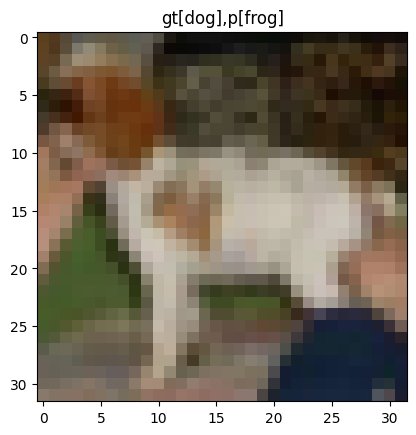

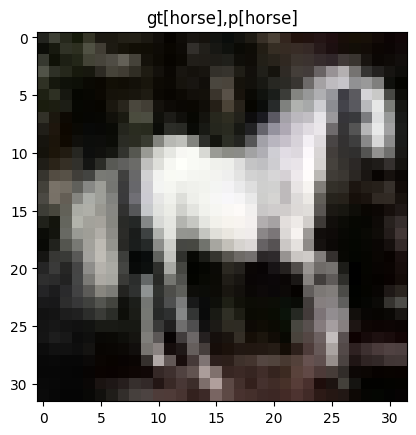

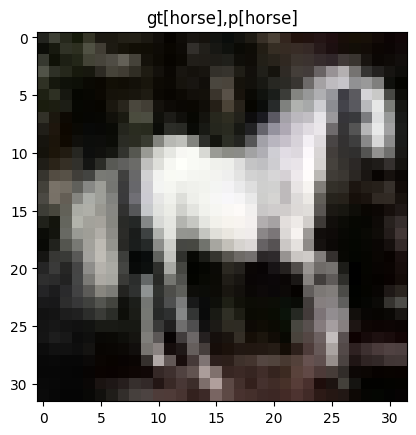

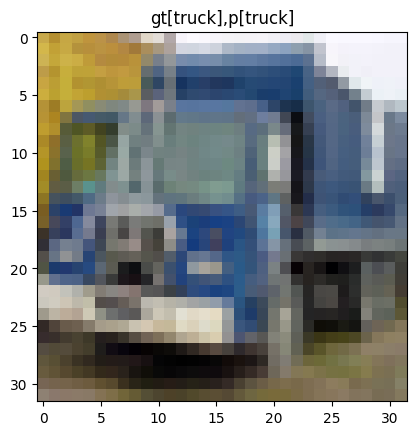

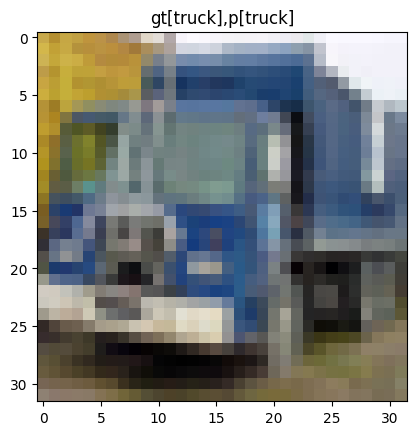

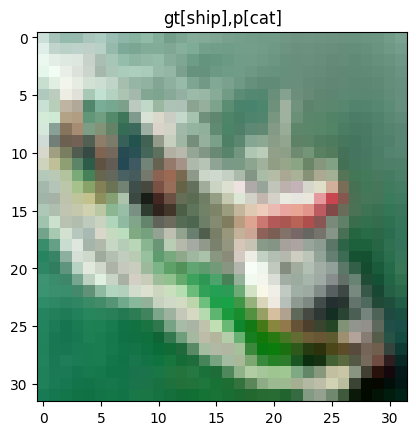

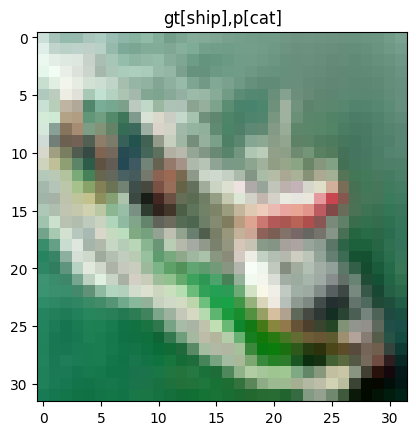

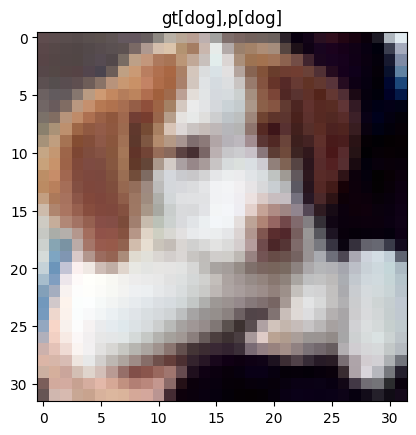

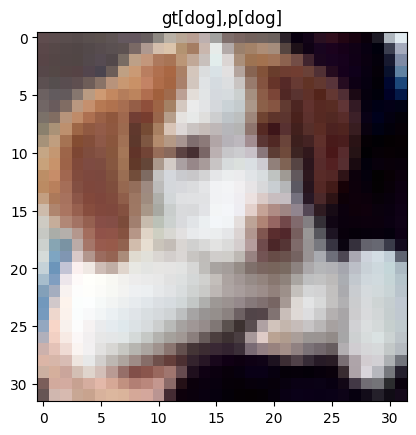

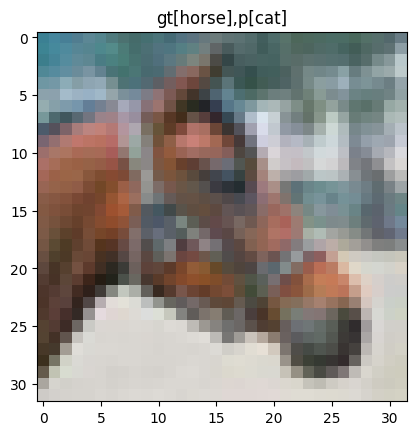

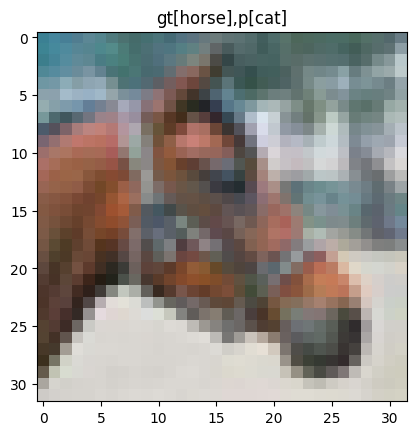

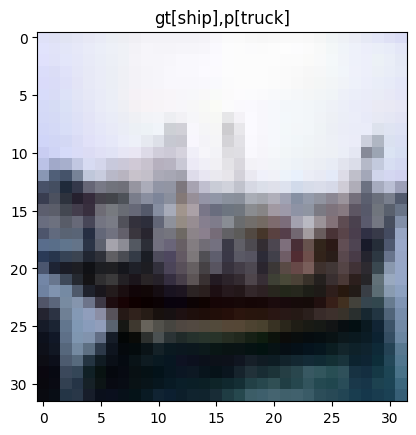

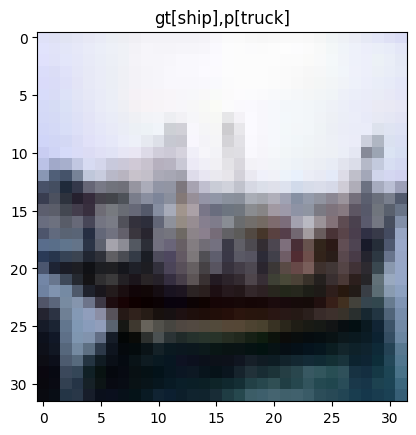

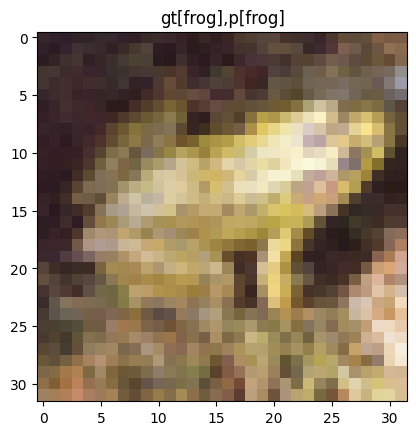

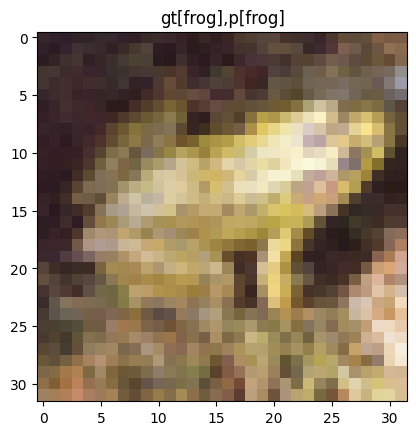

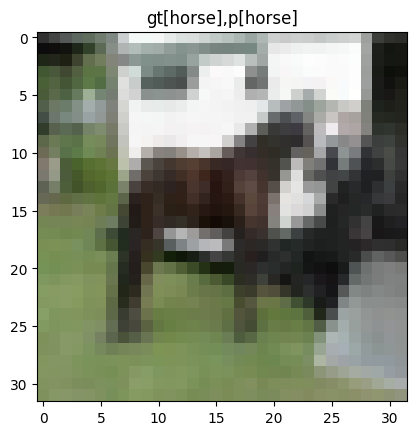

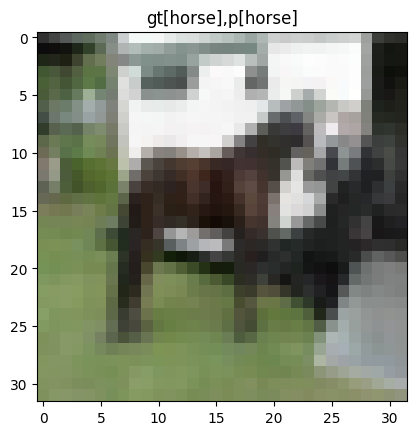

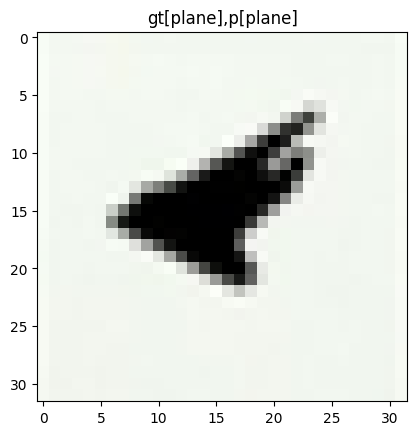

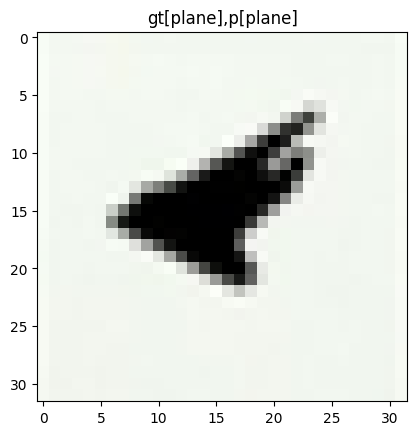

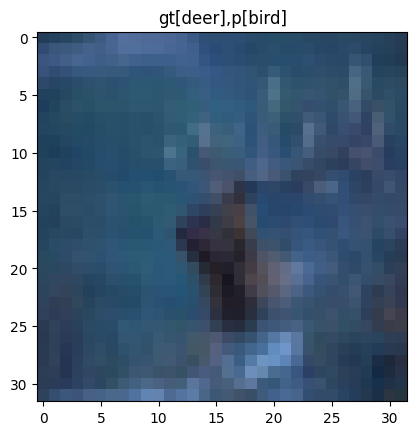

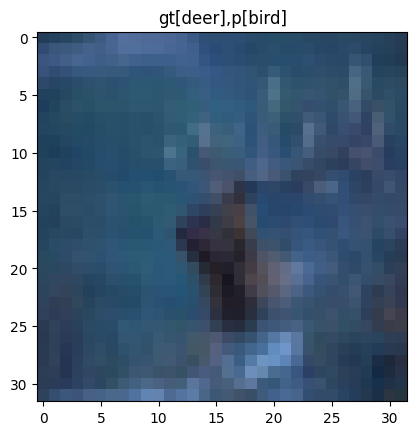

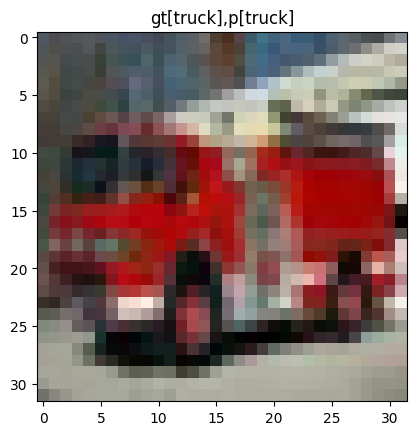

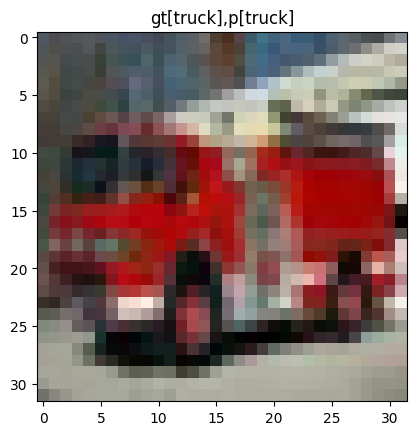

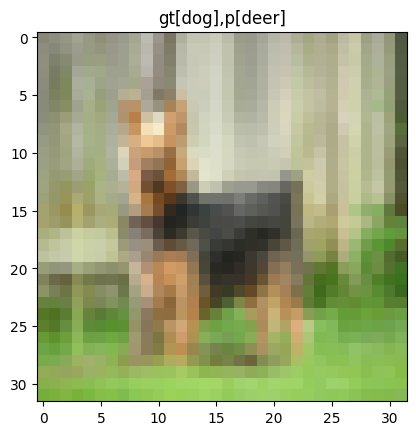

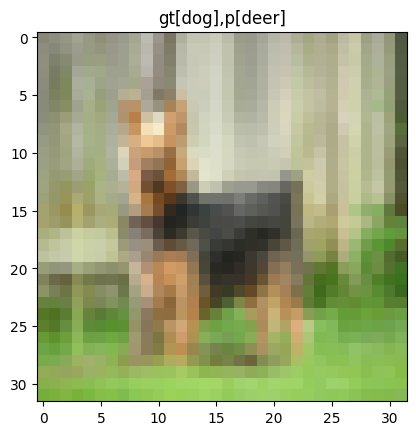

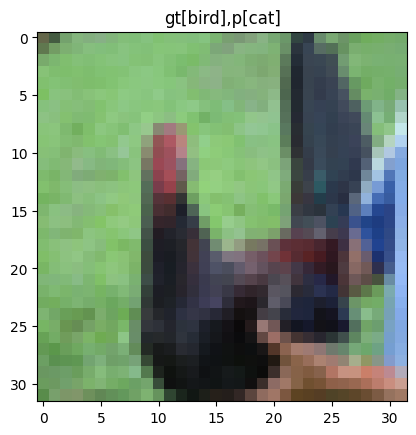

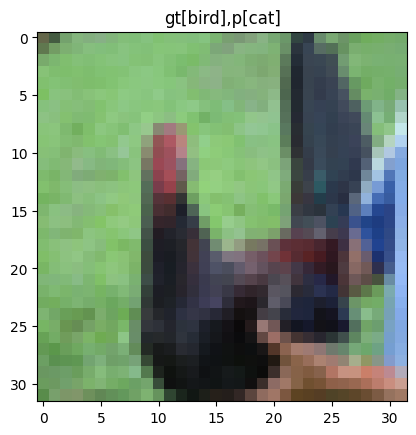

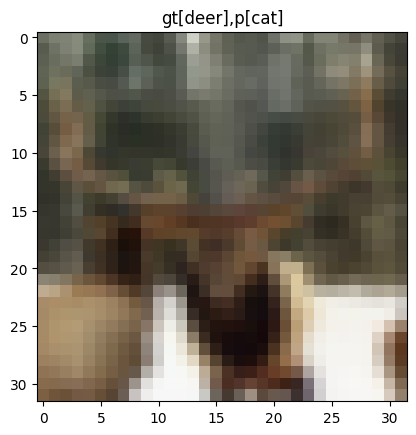

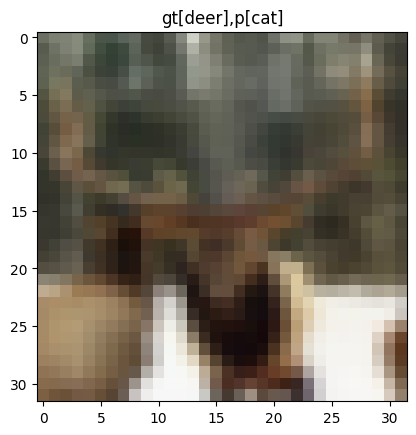

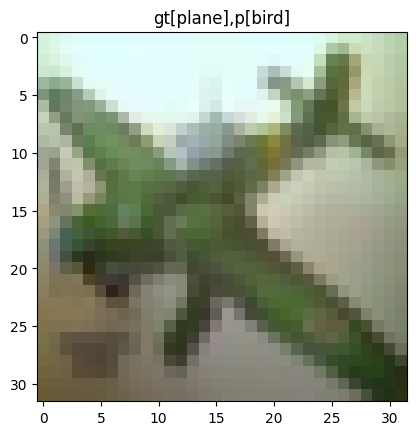

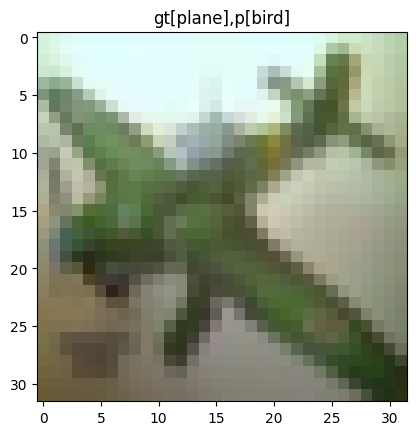

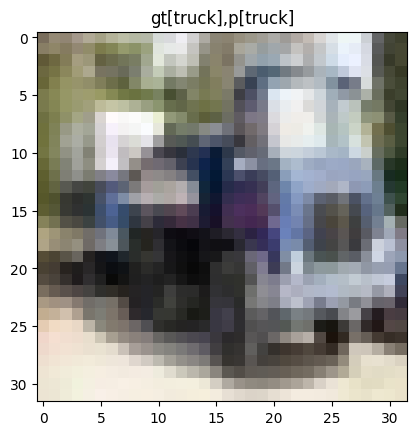

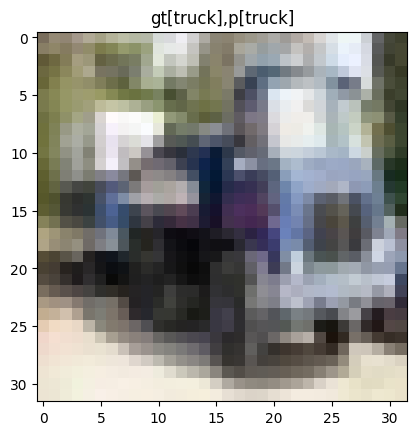

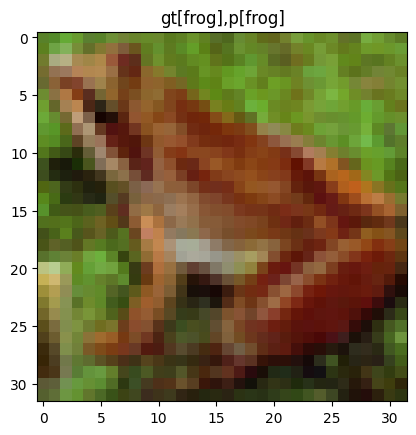

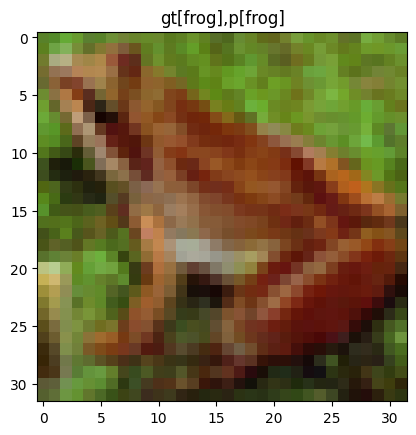

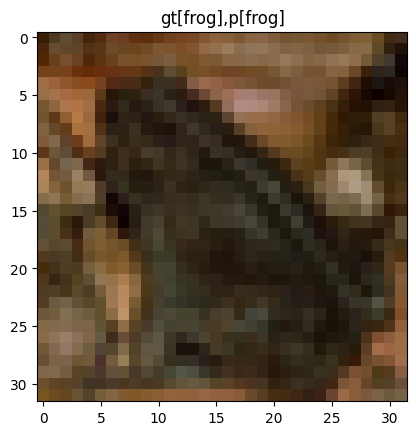

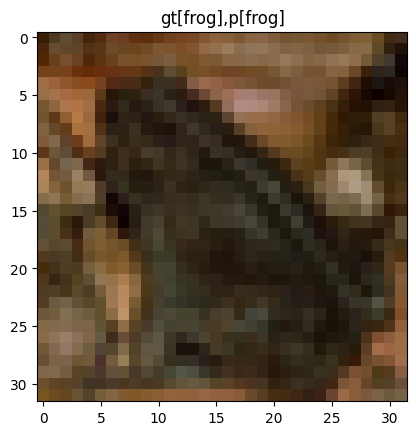

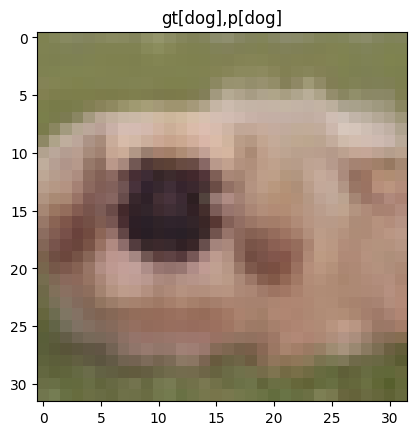

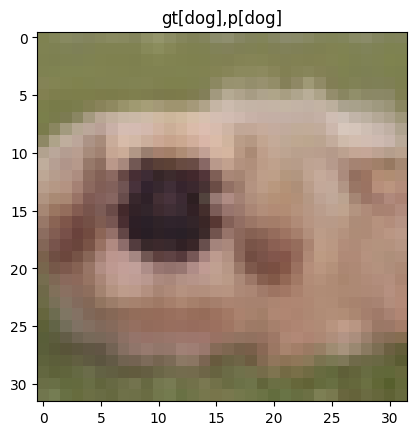

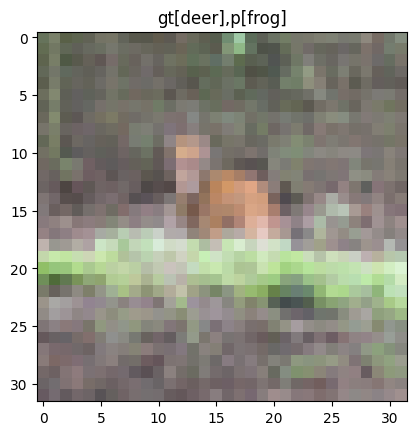

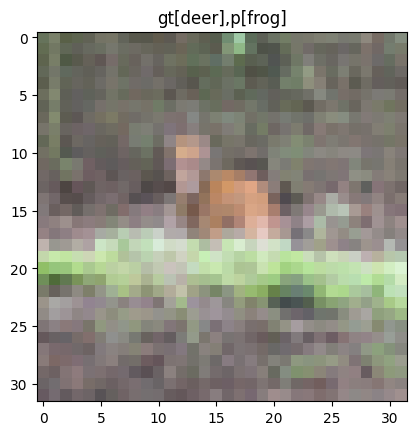

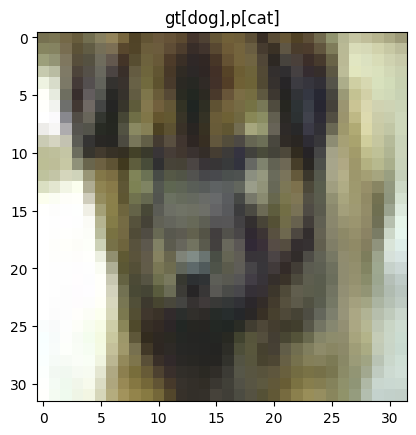

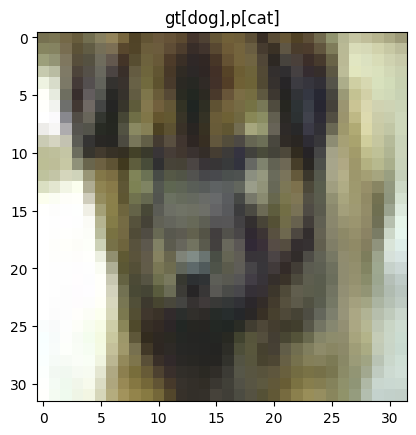

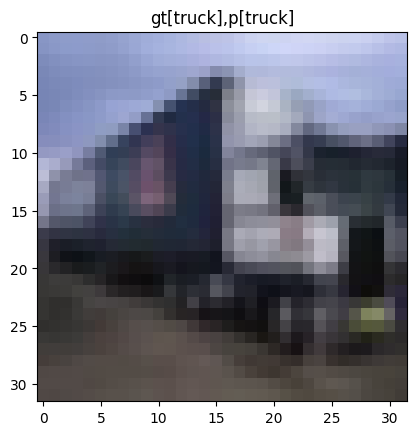

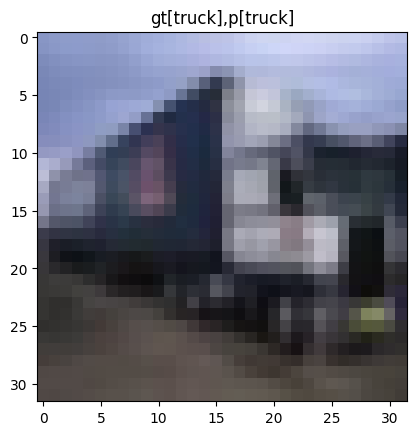

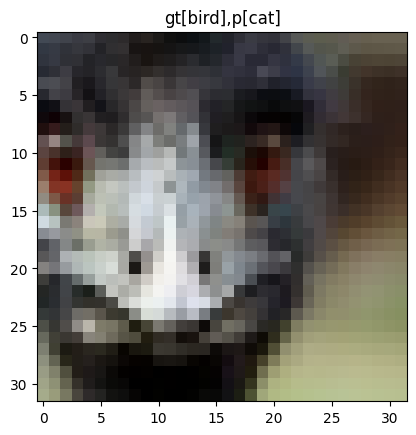

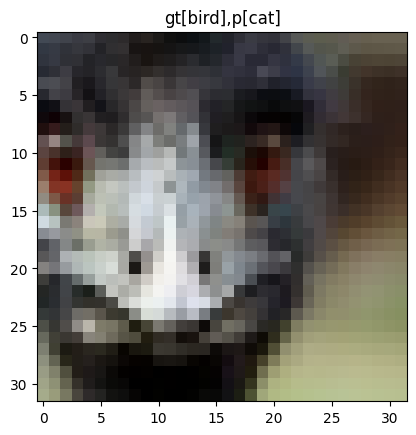

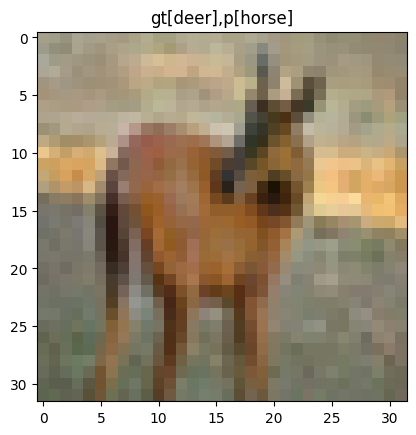

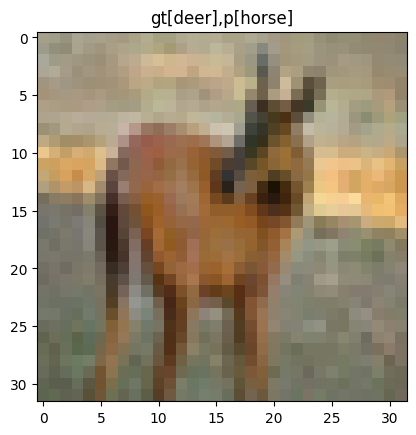

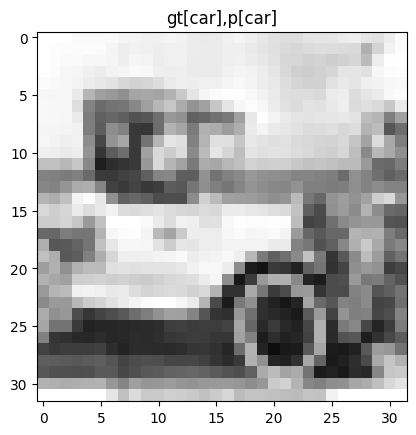

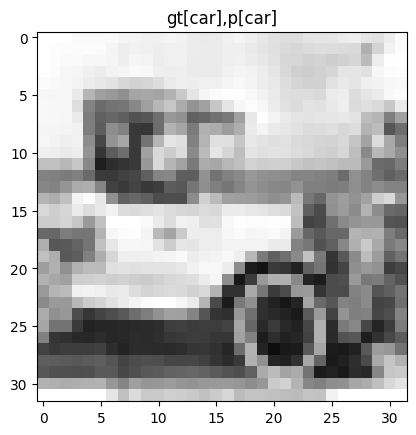

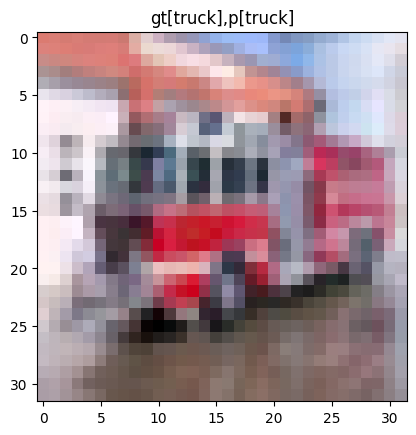

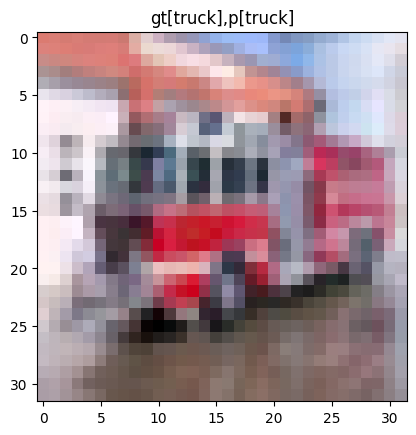

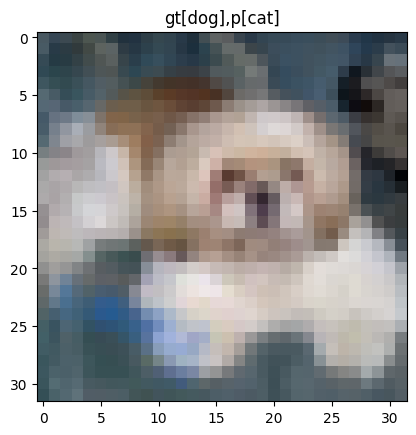

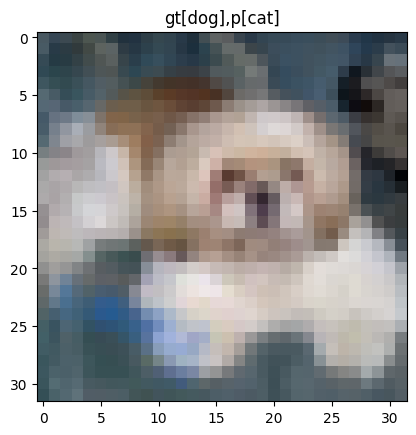

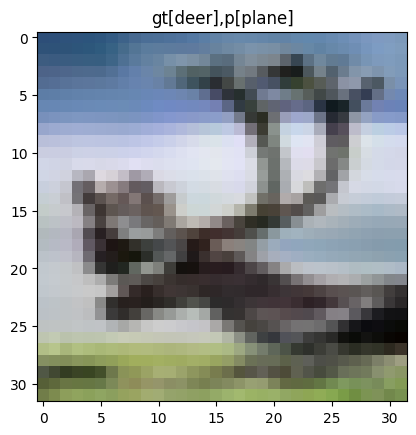

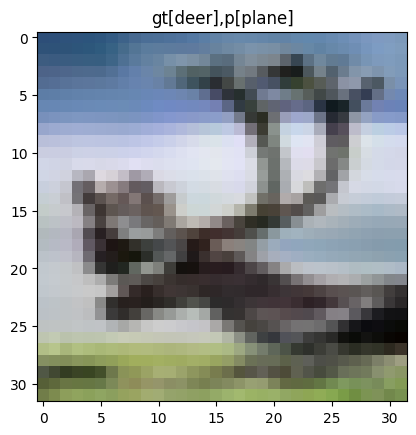

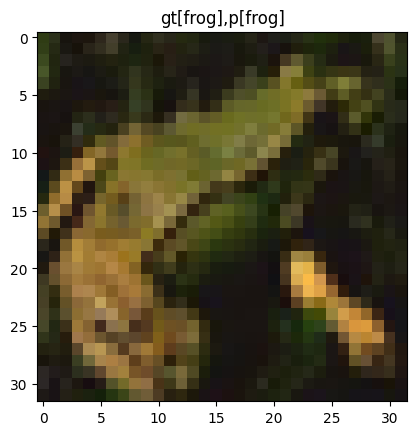

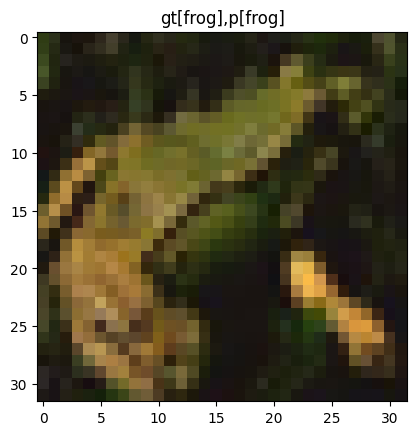

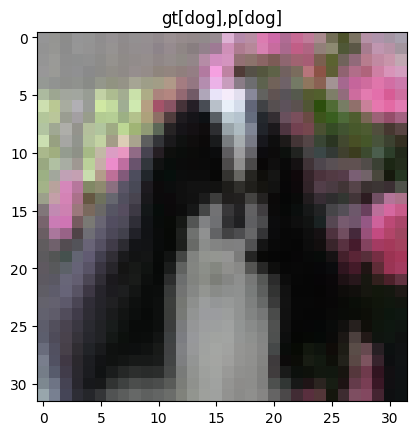

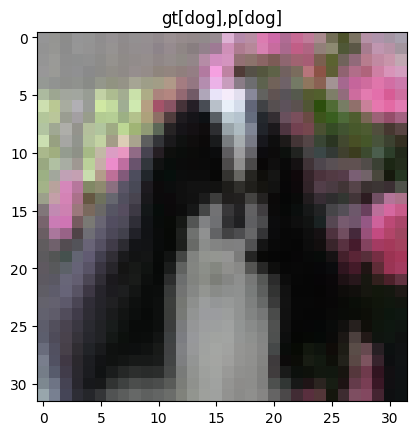

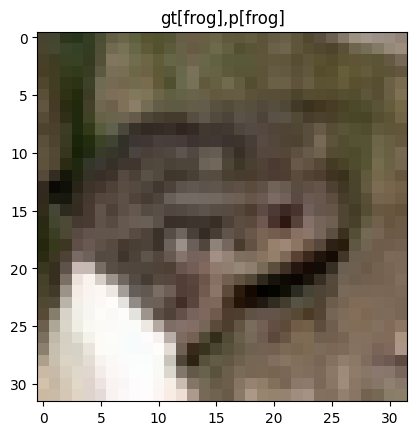

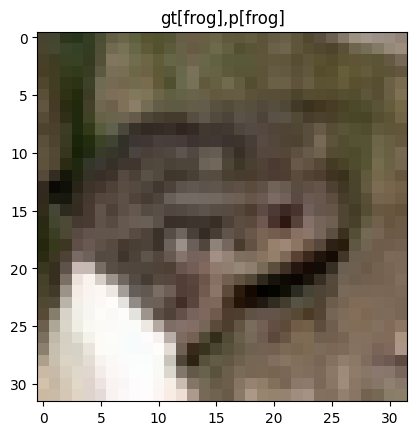

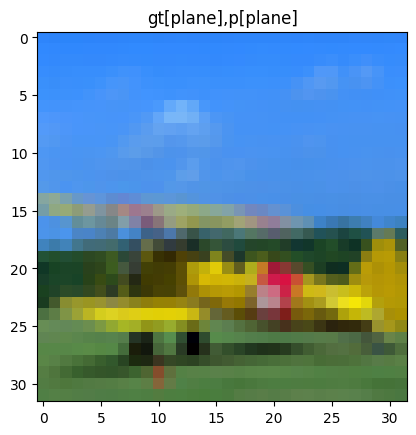

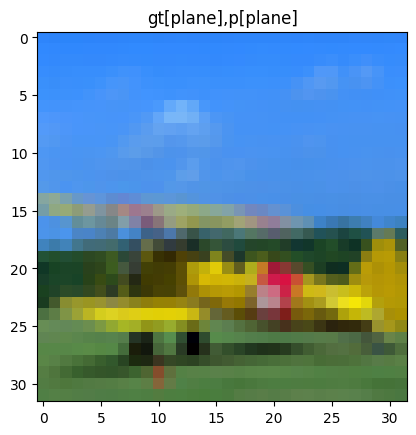

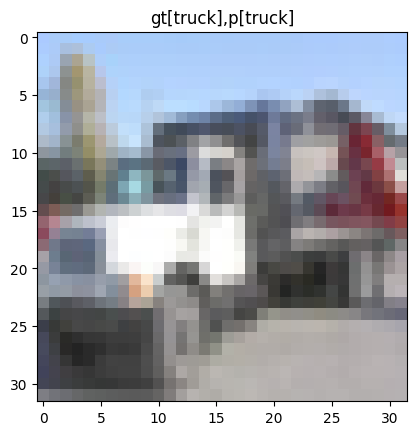

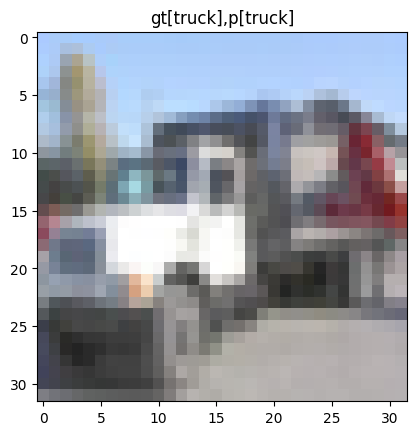

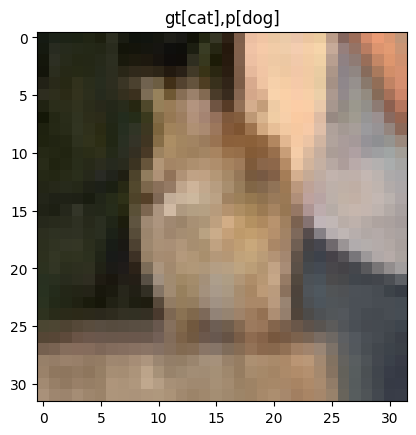

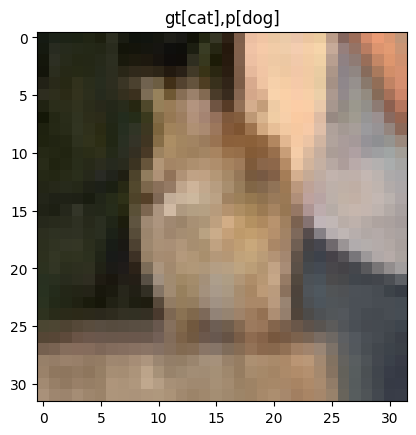

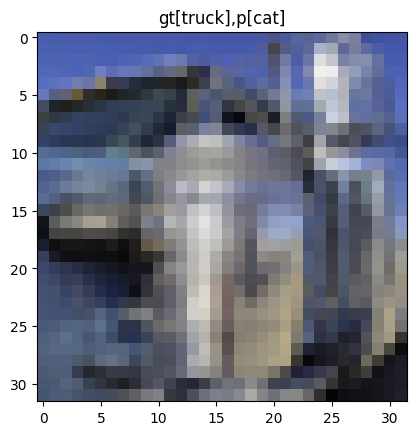

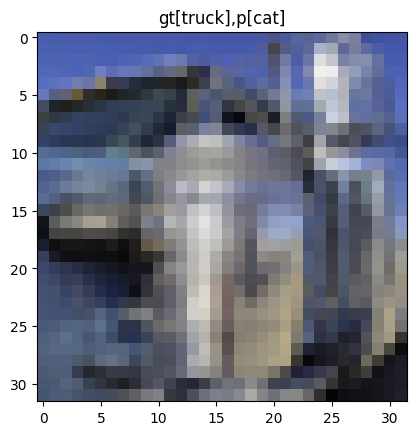

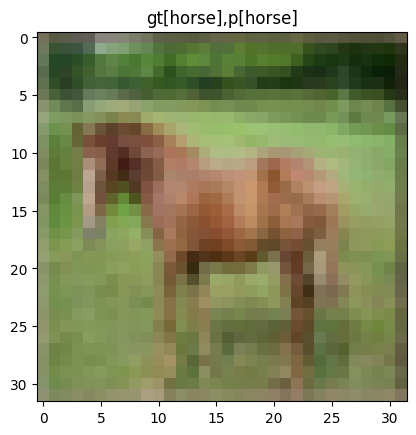

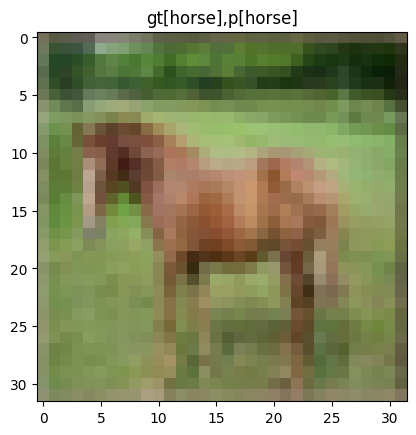

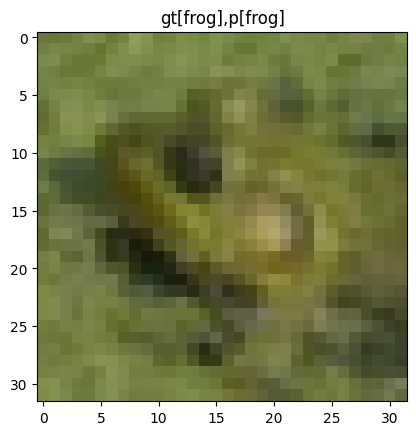

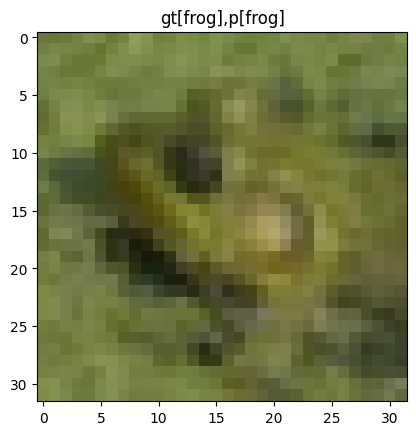

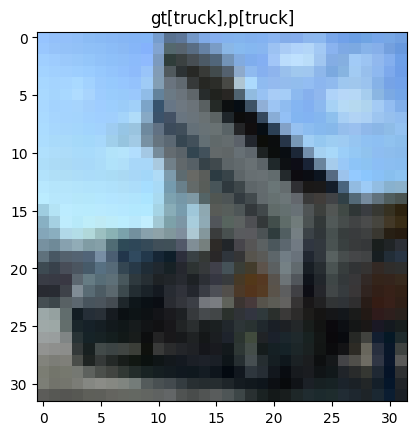

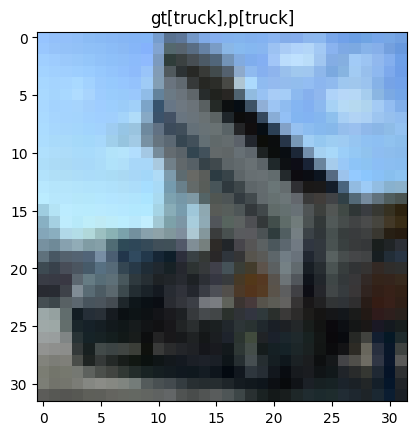

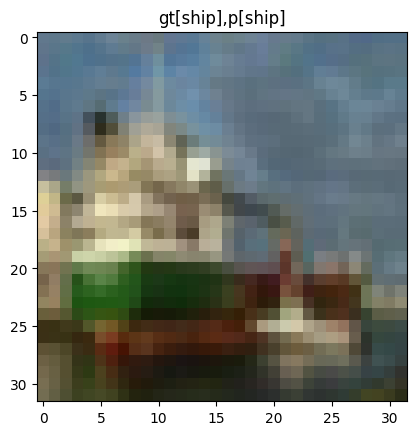

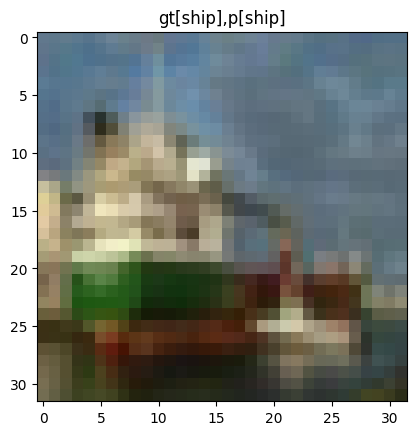

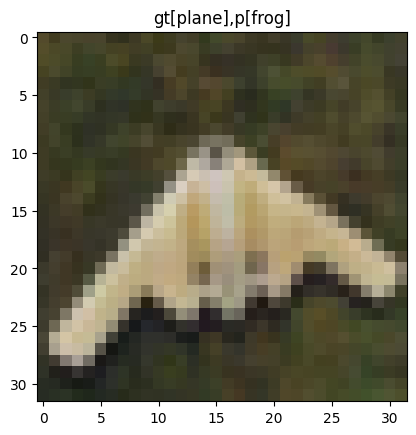

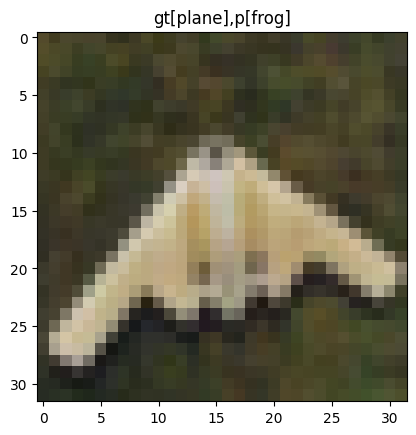

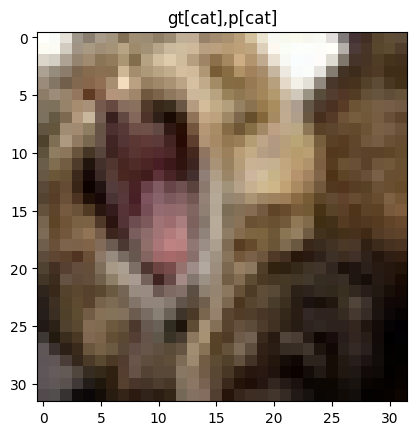

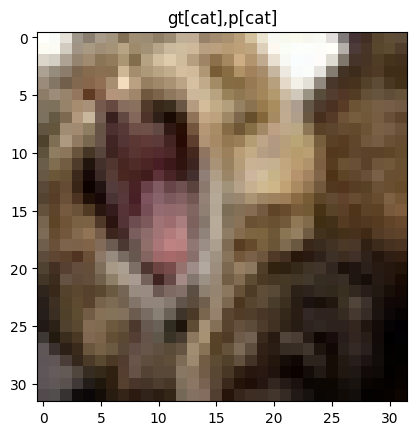

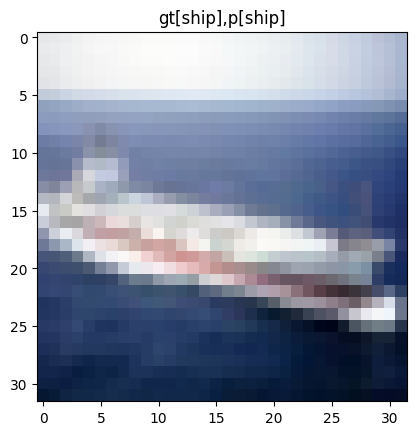

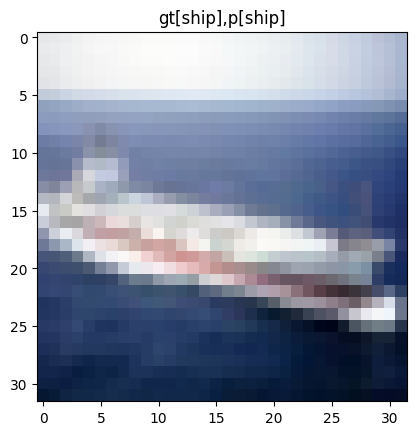

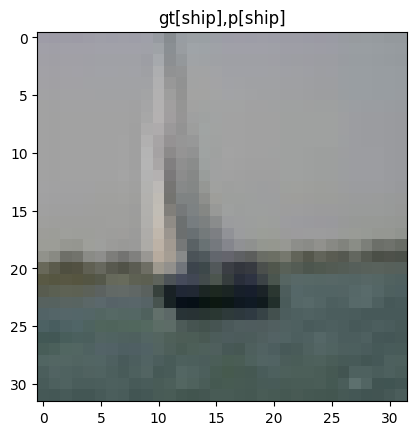

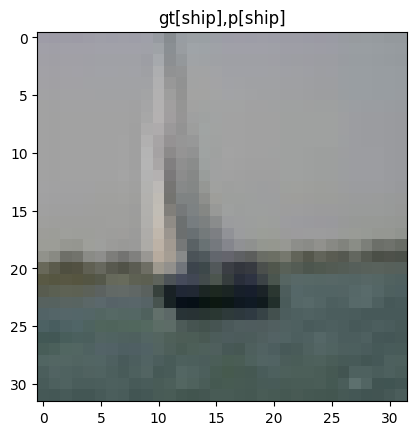

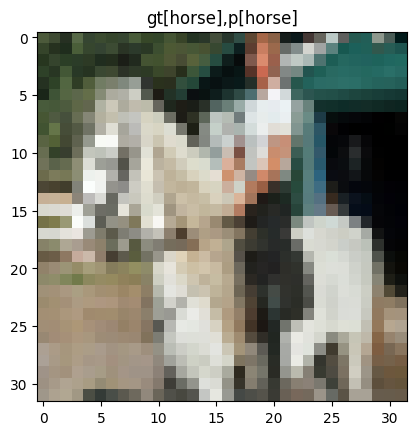

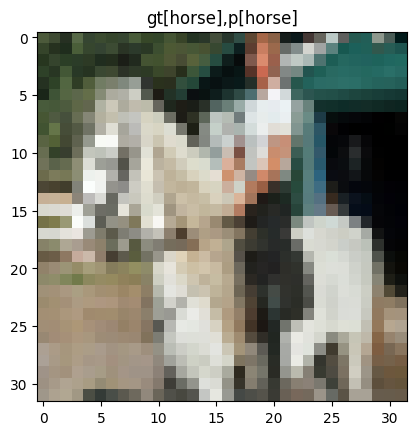

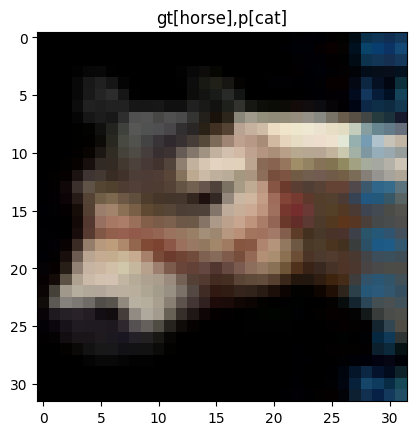

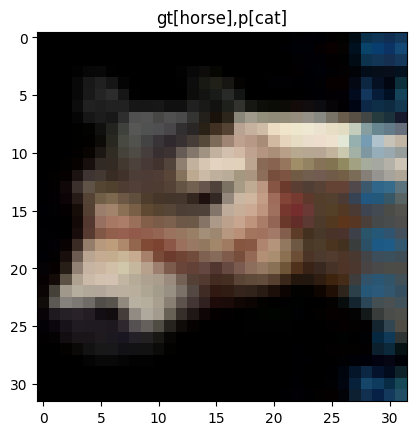

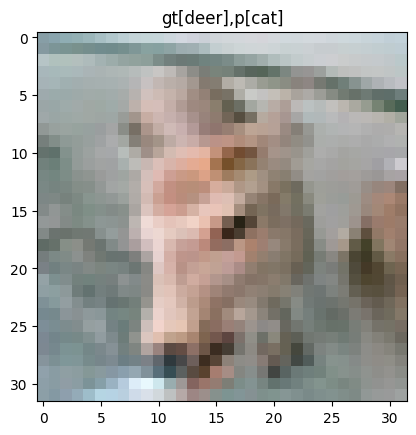

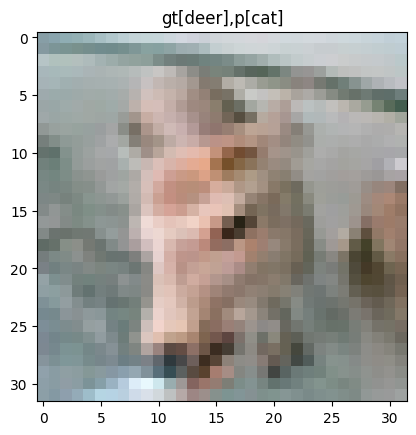

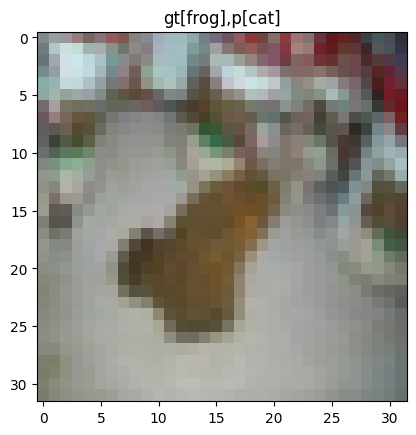

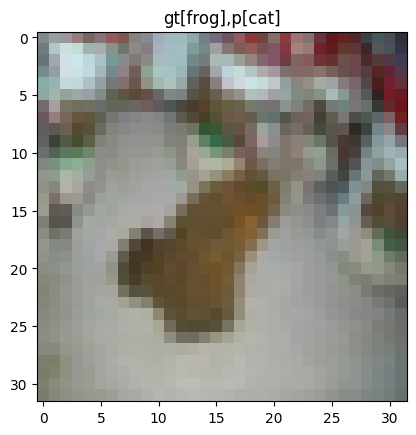

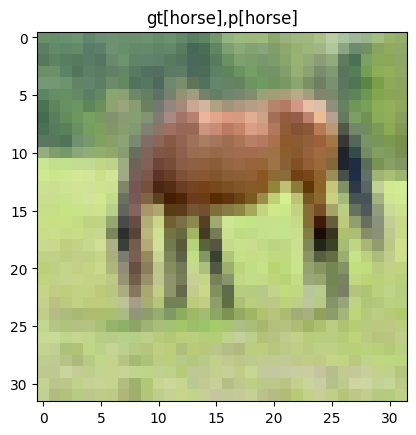

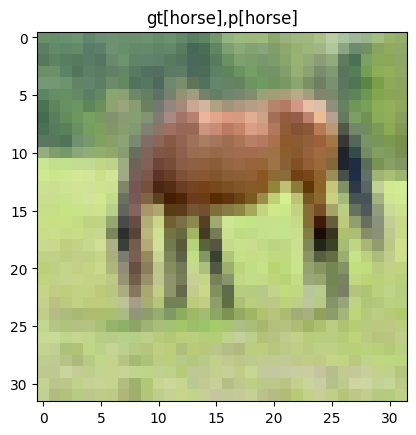

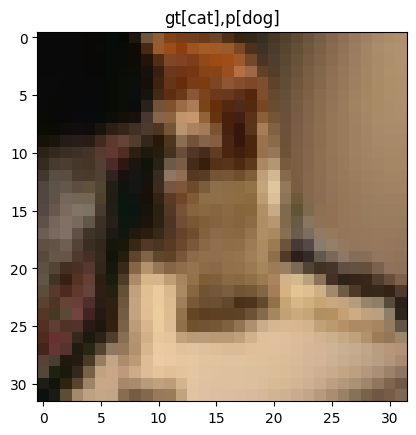

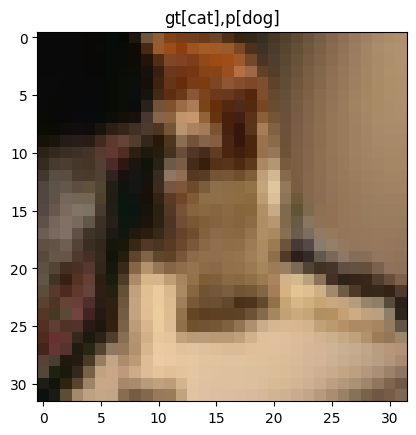

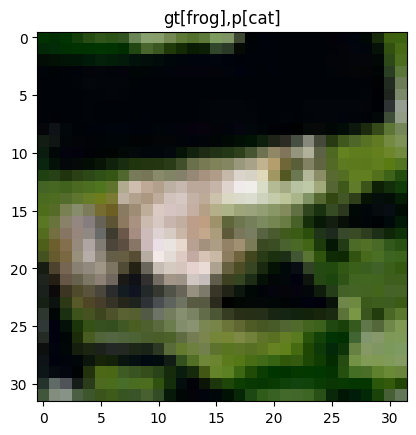

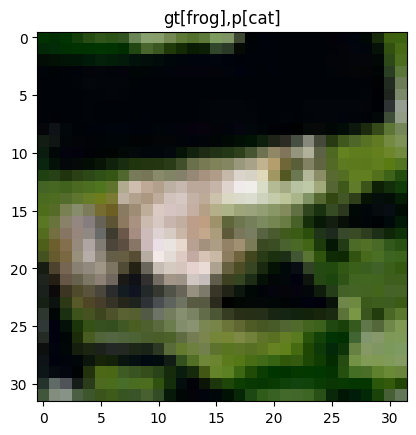

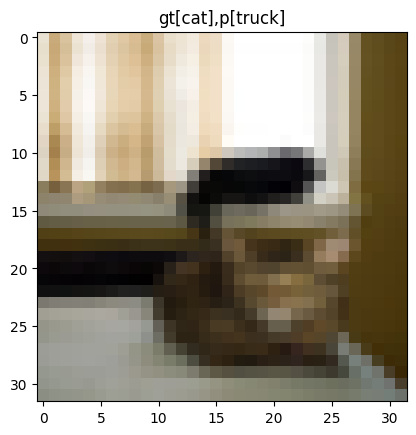

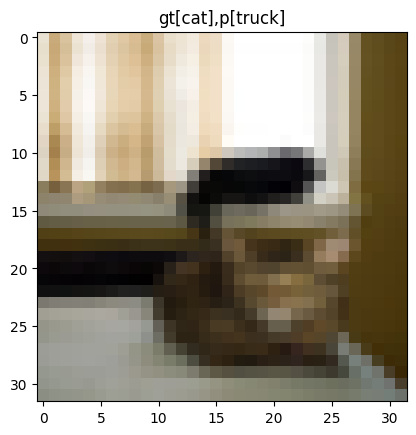

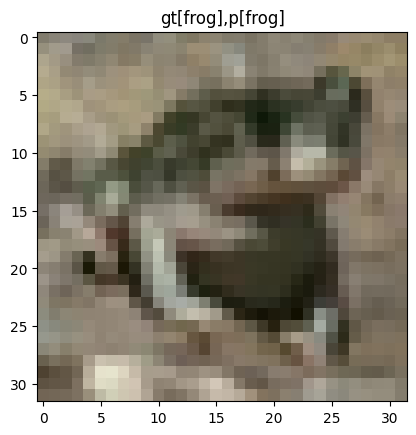

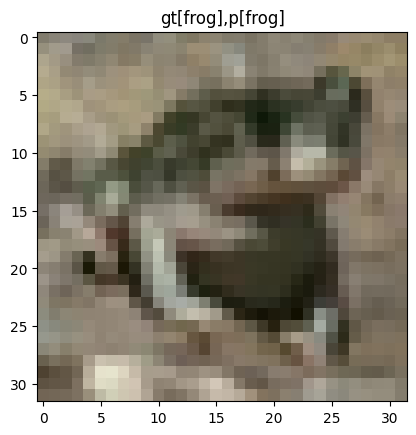

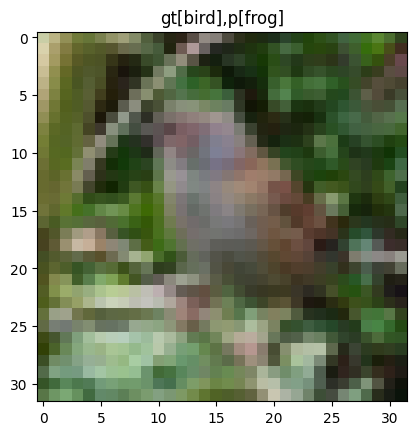

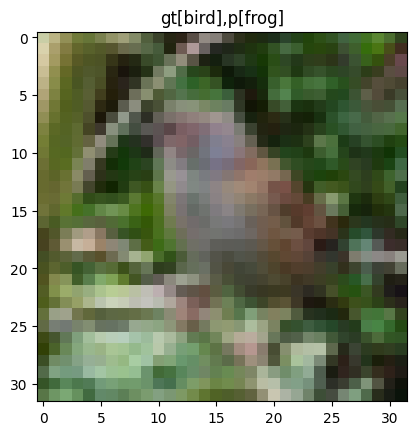

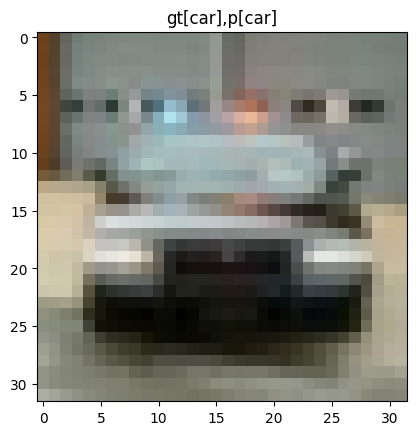

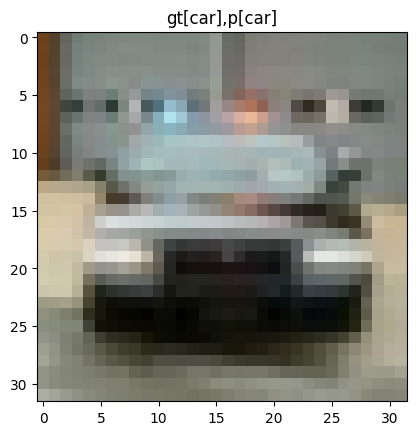

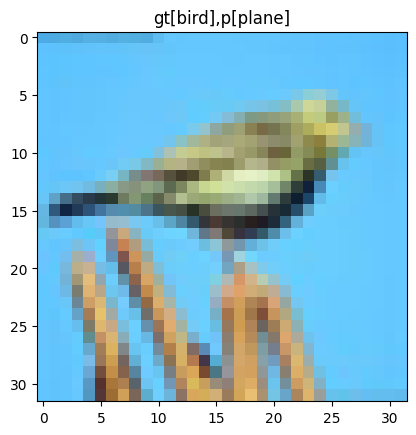

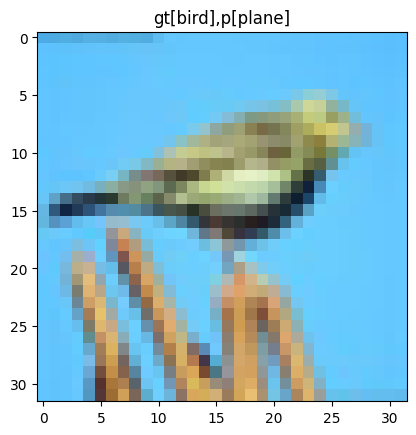

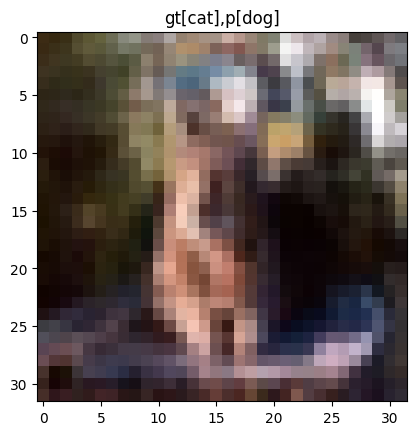

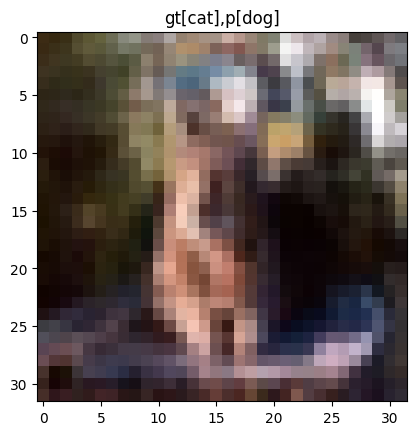

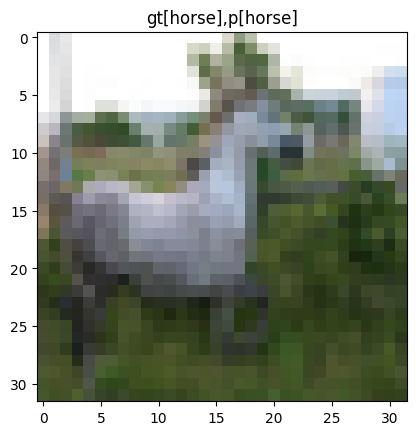

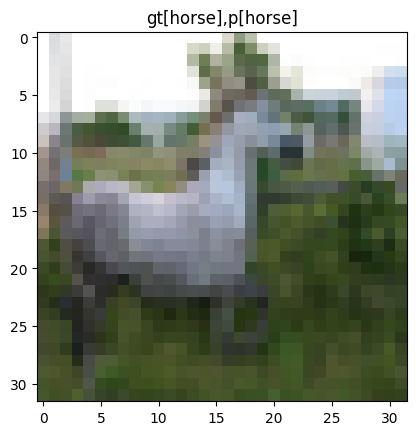

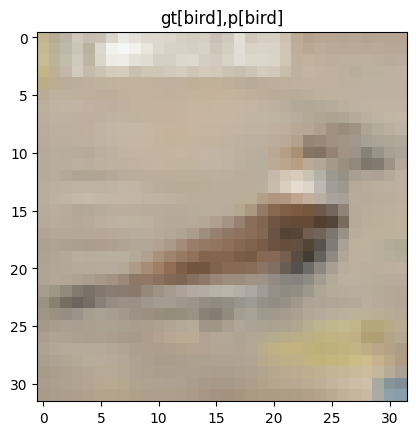

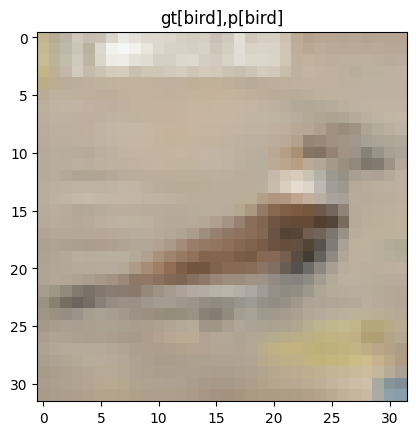

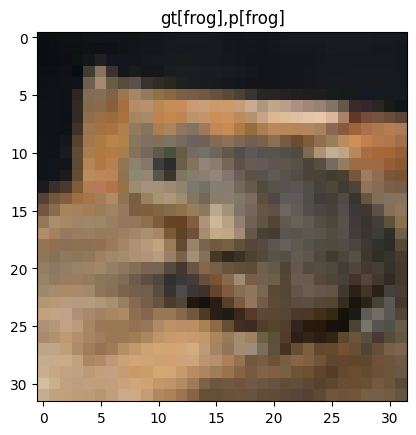

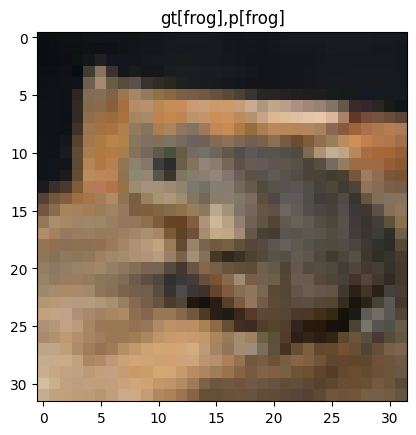

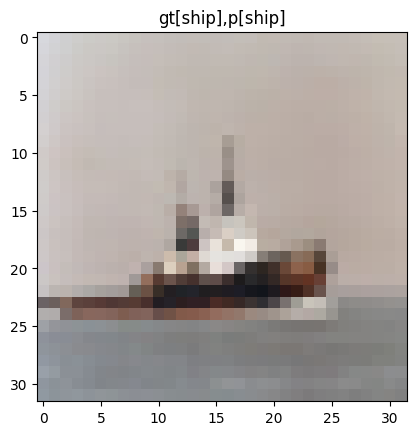

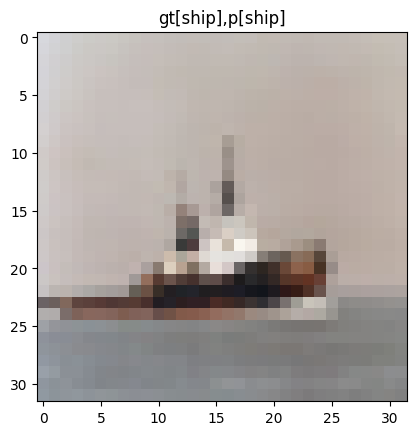

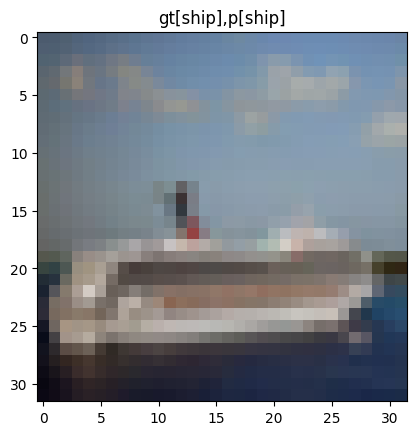

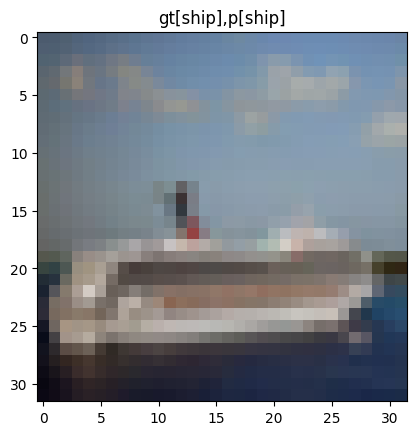

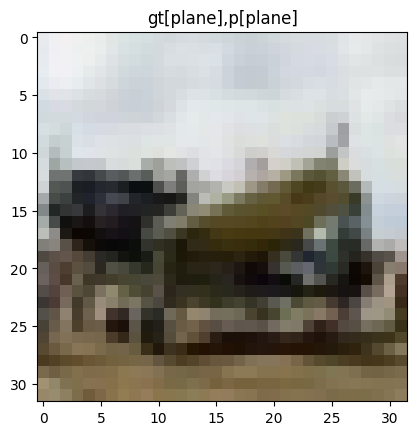

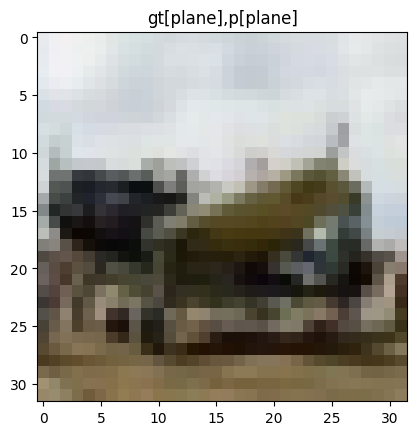

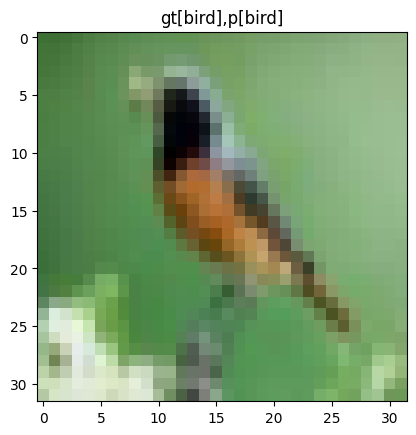

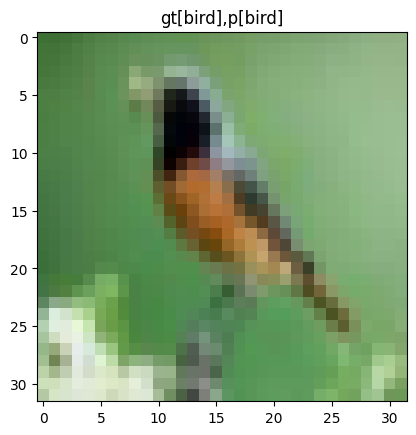

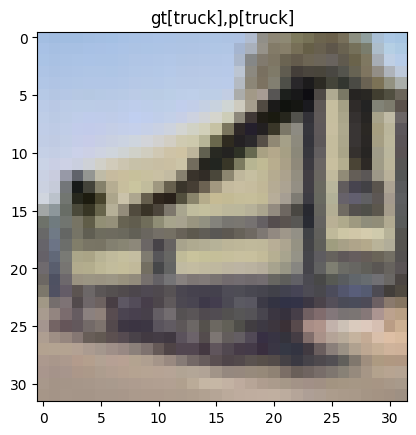

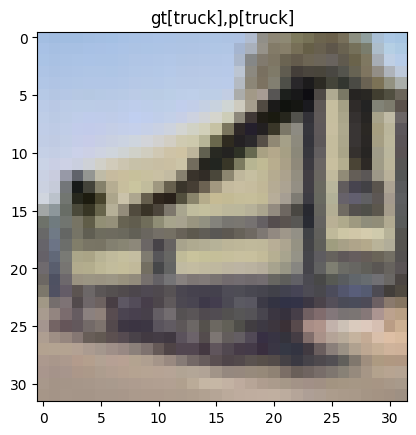

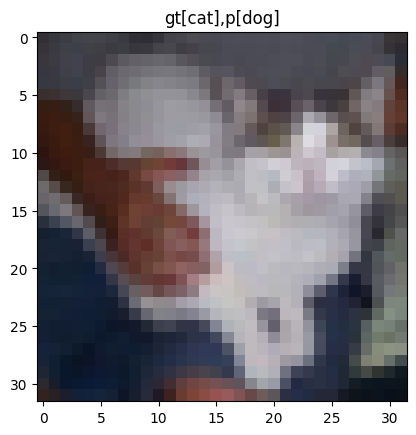

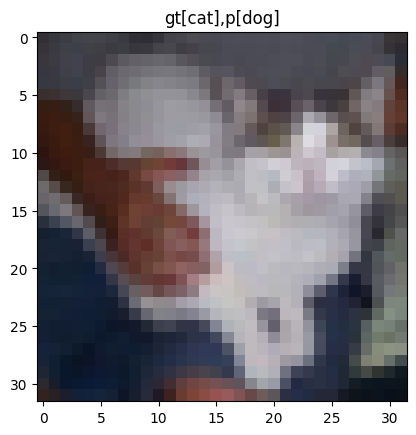

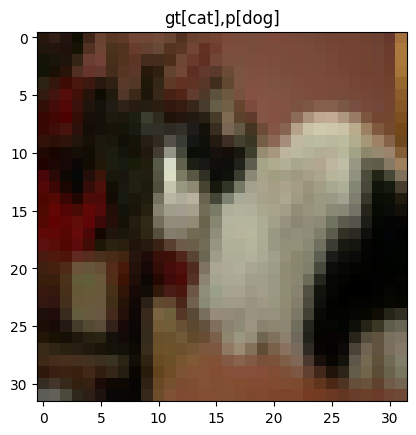

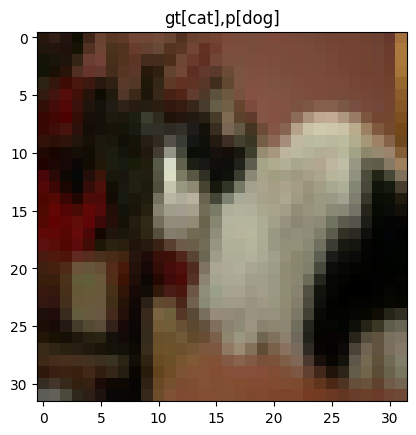

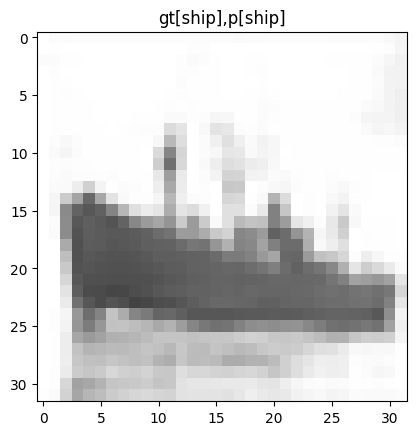

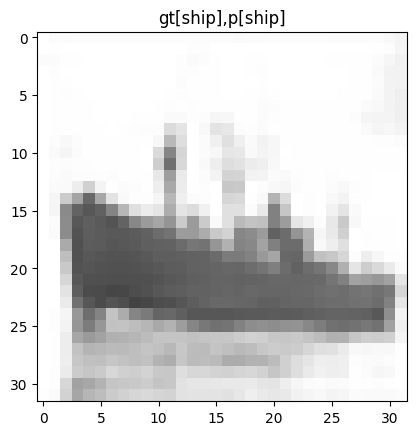

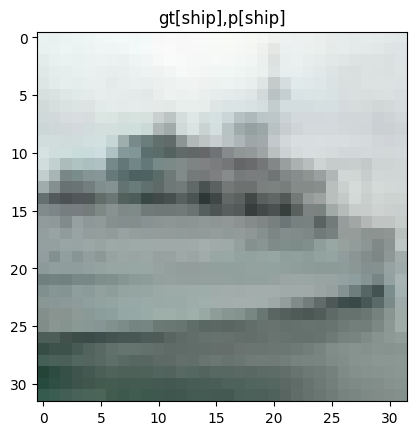

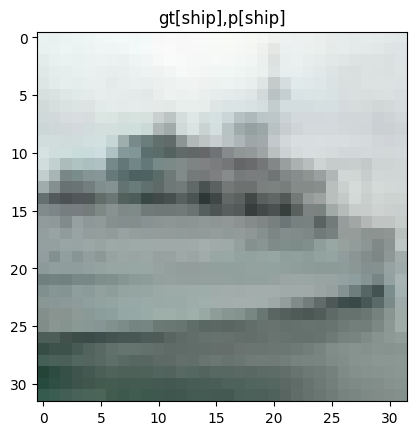

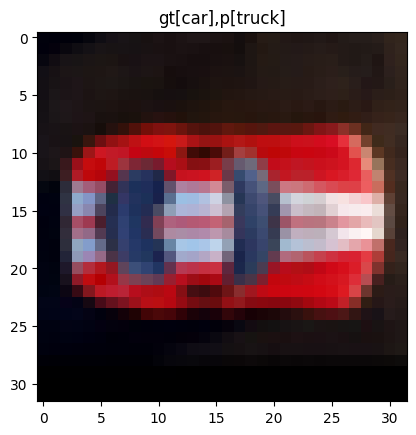

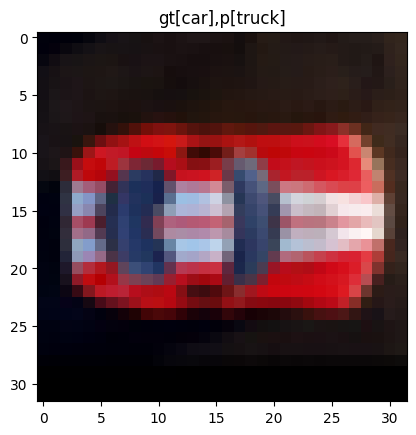

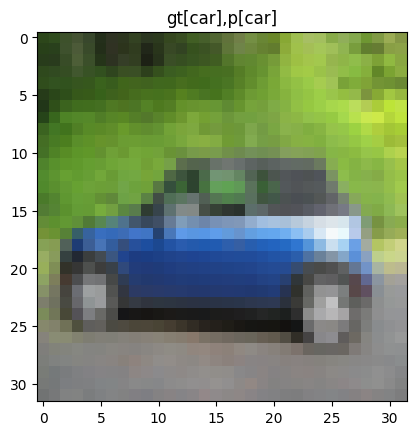

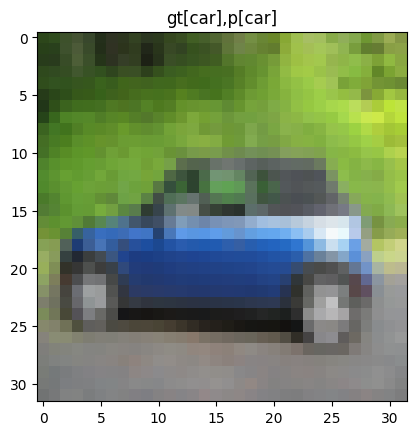

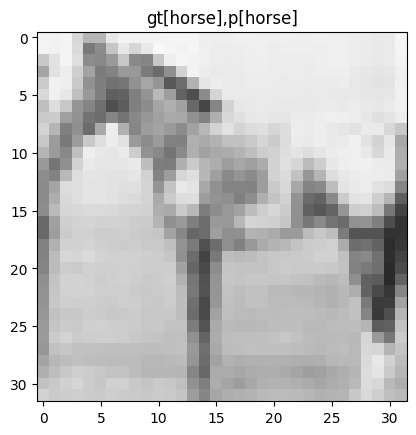

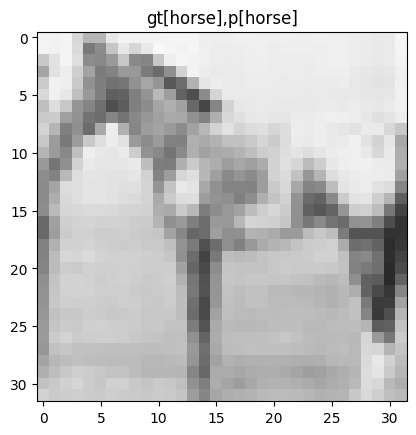

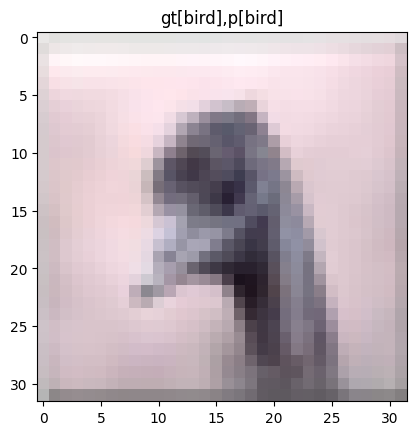

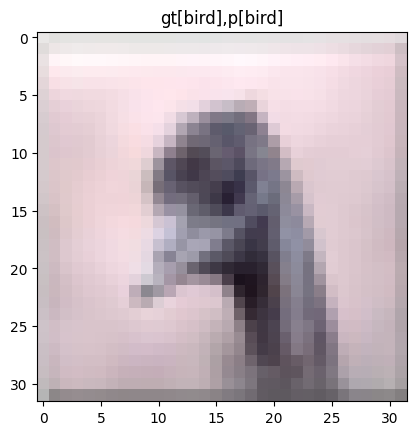

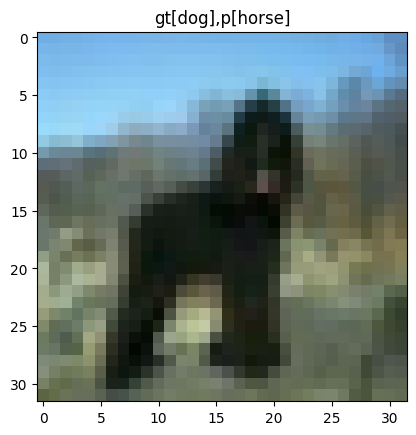

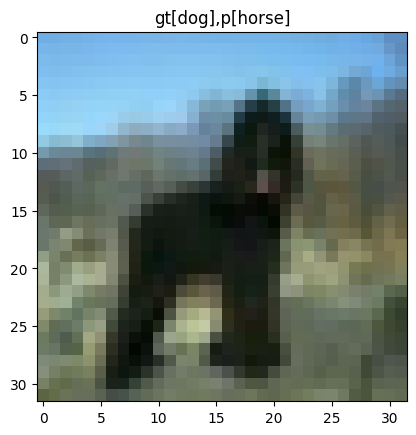

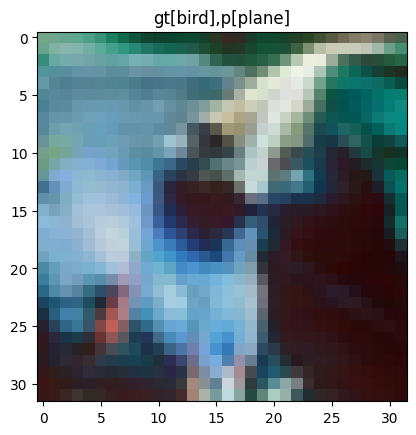

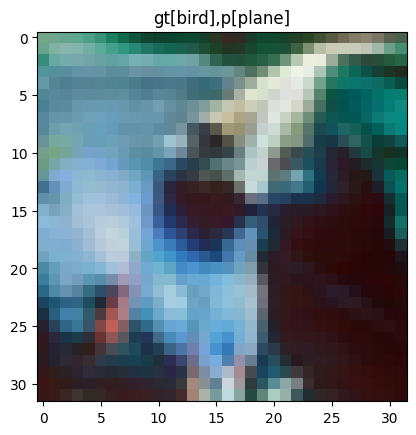

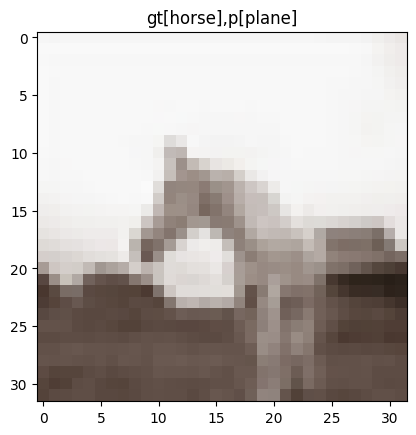

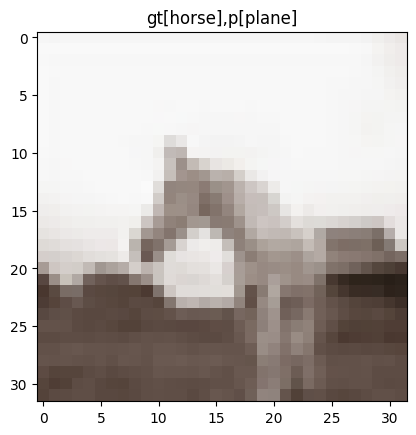

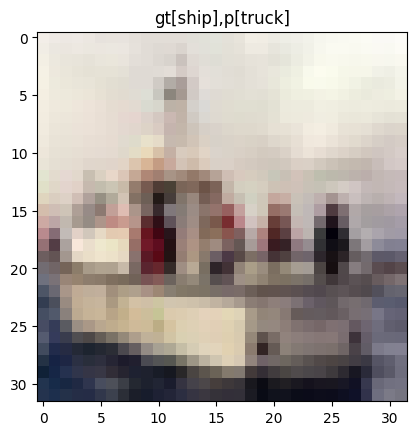

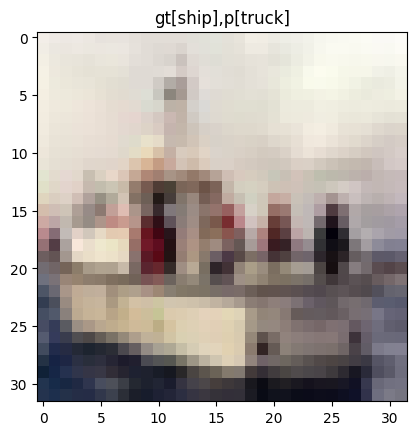

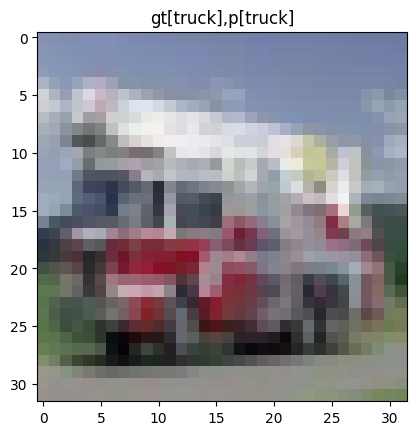

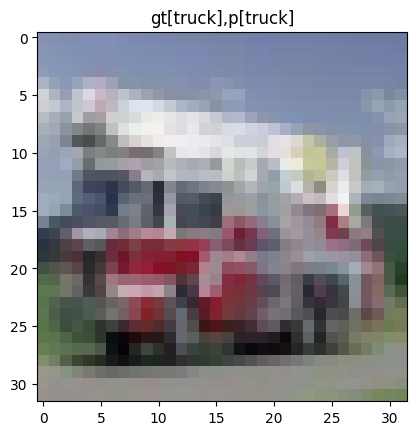

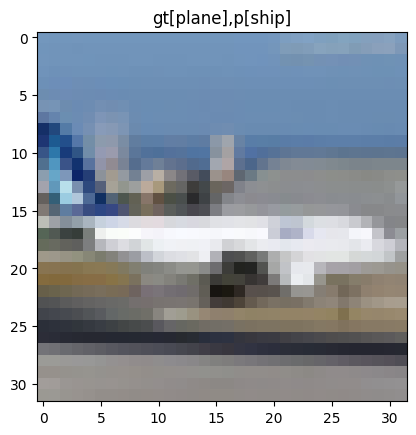

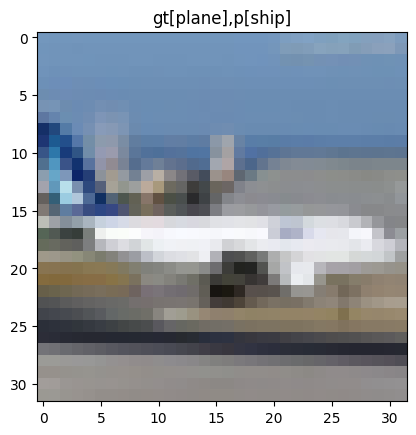

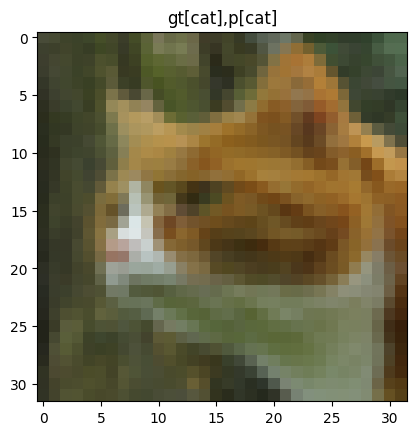

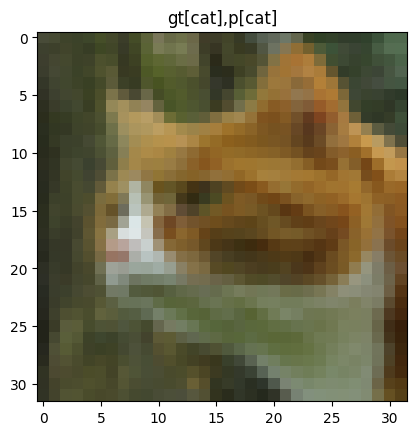

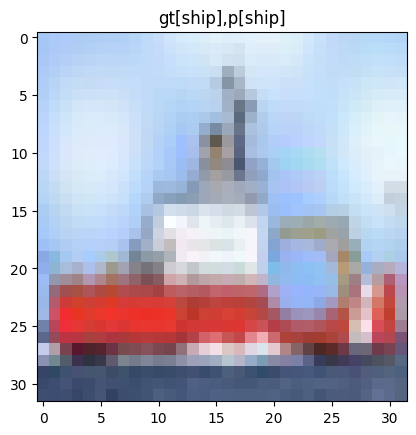

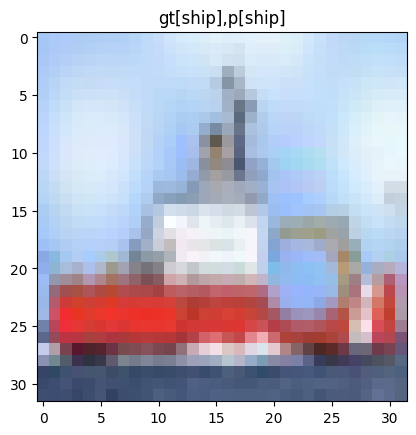

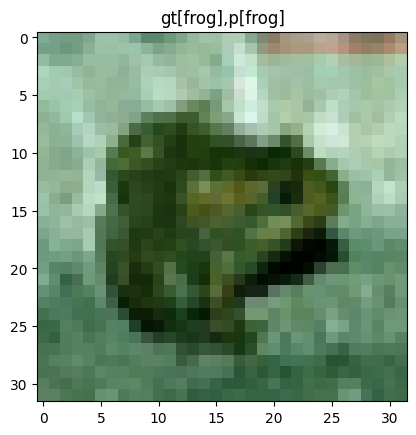

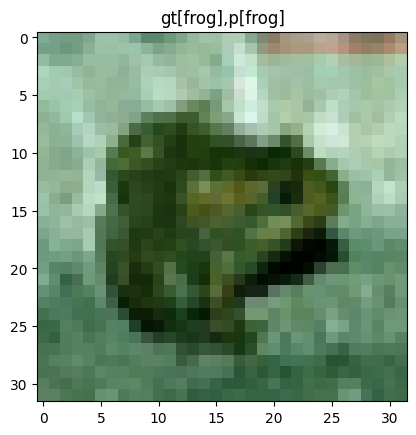

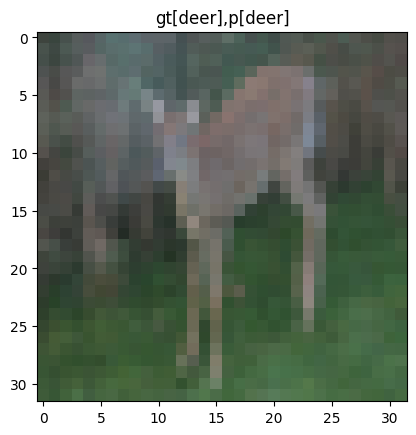

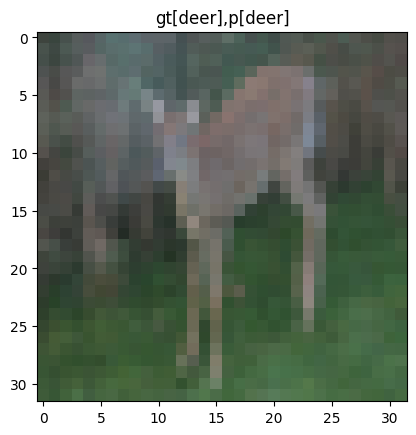

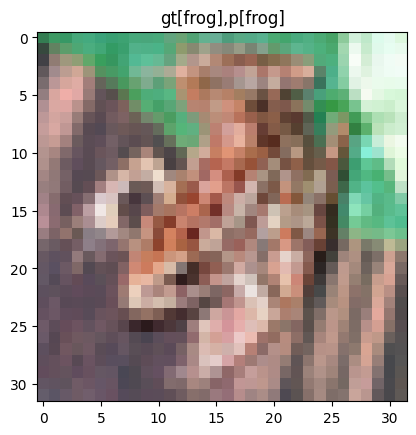

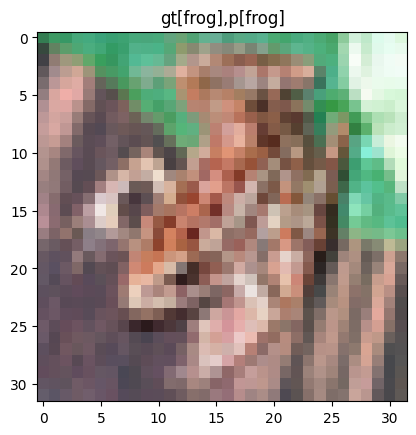

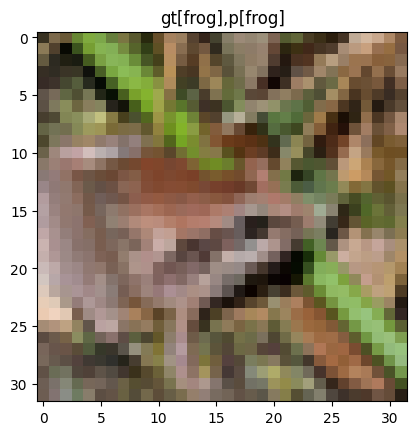

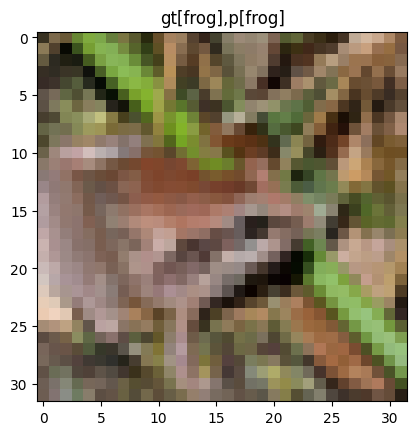

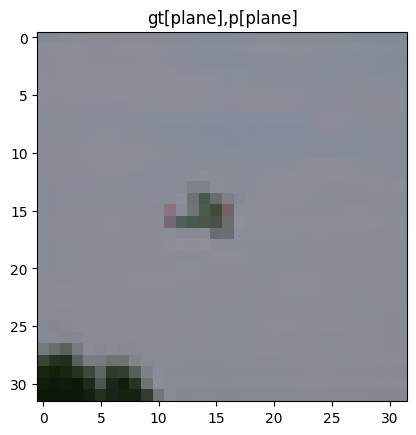

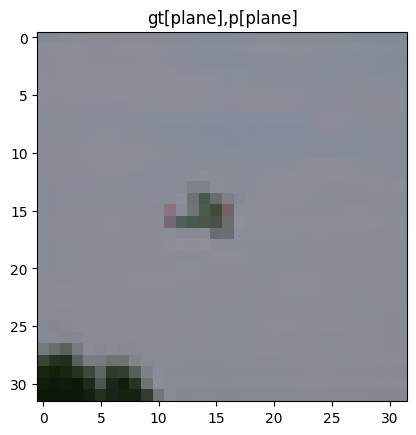

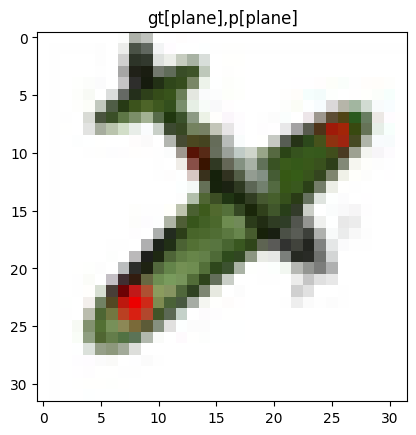

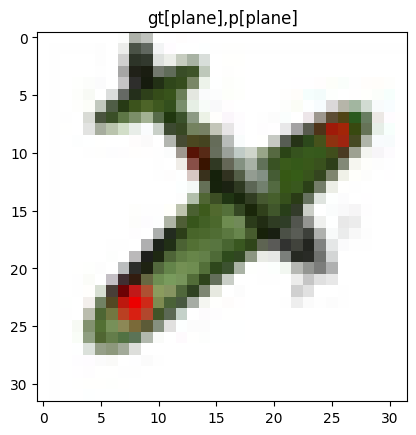

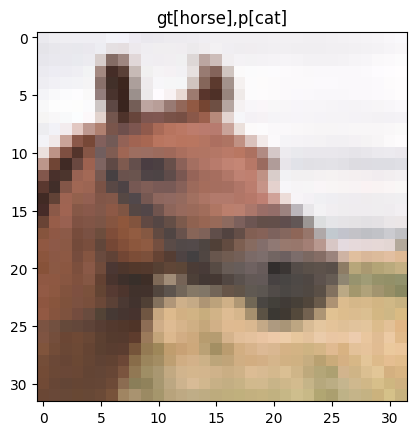

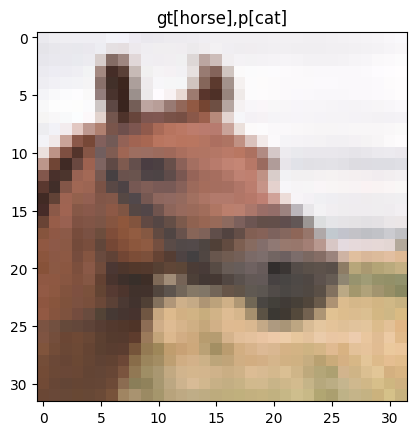

In [86]:
display_torch_result(images, labels, predicts)